## Notebook for reading and visualizing the DiTing dataset ,as well as, STEAD, INSTANCE, SCSN, NEIC datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from collections import Counter
import h5py
import os

# workaround import
import sys
# path to dtt
sys.path.append('../../../DiTingTools_v0701/')

In [2]:
# raw data level
from dtt.dev.det_pick.data import get_from_DiTing, get_from_STEAD, get_from_INSTANCE, get_from_SCSN_FMP, get_from_SCSN_P

# training instance level
from dtt.dev.det_pick.data import get_shifted_instance_for_EqDetPhasePicking_training, get_augmented_instance_for_EqDetPhasePicking_training

# generator level
from dtt.dev.det_pick.data import DiTingGenerator, DiTingRealNoiseGenerator, DiTingSynNoiseGenerator

# TFDataset level
from dtt.dev.det_pick.data import get_det_pick_training_dataset

In [3]:
# 在此修改数据集路径
# change path here
DiTingDatasetPath = '/mnt/GPT_disk/DL_datasets/DiTing330km_publish_50Hz/'
# 加载数据集CSV文件
# load csv file
DiTing_330km_csv = pd.read_csv(DiTingDatasetPath + 'DiTing330km_total.csv',dtype = {'key': str})
# CSV文件各列信息
# show columns in CSV file
print('Csv Index Info:')
print(DiTing_330km_csv.keys())

/public/home/zhaoming/guochang/miniconda3/envs/DiTingDevEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (5,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Csv Index Info:
Index(['Unnamed: 0', 'Unnamed: 0.1', 'part', 'key', 'ev_id', 'evmag',
       'mag_type', 'p_pick', 'p_clarity', 'p_motion', 's_pick', 'net',
       'sta_id', 'dis', 'st_mag', 'baz', 'Z_P_amplitude_snr', 'Z_P_power_snr',
       'Z_S_amplitude_snr', 'Z_S_power_snr', 'N_P_amplitude_snr',
       'N_P_power_snr', 'N_S_amplitude_snr', 'N_S_power_snr',
       'E_P_amplitude_snr', 'E_P_power_snr', 'E_S_amplitude_snr',
       'E_S_power_snr', 'P_residual', 'S_residual'],
      dtype='object')


In [4]:
# 展示地震记录数目
# show trace num
print('Total trace number: {}'.format(len(DiTing_330km_csv)))

Total trace number: 2734748


In [5]:
# 展示csv文件前若干行
# show rows in CSV file
DiTing_330km_csv[:5]

,Unnamed: 0,Unnamed: 0.1,part,key,ev_id,evmag,mag_type,p_pick,p_clarity,p_motion,...,N_P_amplitude_snr,N_P_power_snr,N_S_amplitude_snr,N_S_power_snr,E_P_amplitude_snr,E_P_power_snr,E_S_amplitude_snr,E_S_power_snr,P_residual,S_residual
0,0,0,0,000001.0004,1,1.5,ML,1743,E,,...,1.500,3.481,2.279,10.628,1.500,3.481,2.279,10.628,0.10,2.24
1,1,1,0,000001.0003,1,1.5,ML,1215,E,,...,1.307,0.067,4.273,16.639,1.307,0.067,4.273,16.639,-0.04,1.17
2,2,2,0,000001.0001,1,1.5,ML,2196,E,,...,0.948,-0.895,1.526,2.751,0.948,-0.895,1.526,2.751,-0.14,1.70
3,3,3,0,000001.0002,1,1.5,ML,2572,,,...,3.510,4.594,1.054,1.272,3.510,4.594,1.054,1.272,-0.62,1.97
4,4,4,0,000002.0007,2,1.0,ML,662,,R,...,3.202,2.393,3.603,10.445,3.202,2.393,3.603,10.445,0.00,0.08


/tmp/ipykernel_37250/3137318586.py:73: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.gca().set_yscale('log', nonposy="clip")
/tmp/ipykernel_37250/3137318586.py:75: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.gca().set_yscale('log', nonposy="clip")


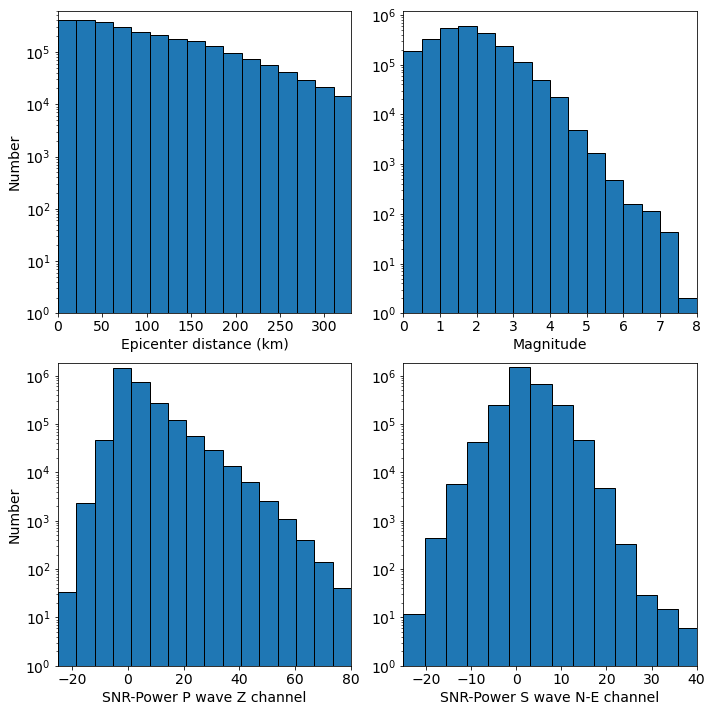

In [6]:
# 获取震中距、震级和信噪比信息
# get distance,magnitude and SNR info
distance_list = list(DiTing_330km_csv['dis'])
# get magnitude info
evmag_list = list()
for t_mag in list(DiTing_330km_csv['evmag']):
    try:
        evmag_list.append(float(t_mag))
    except:
        pass

Z_P_Power_snr = list(DiTing_330km_csv['Z_P_power_snr'])
N_S_Power_snr = list(DiTing_330km_csv['N_S_power_snr'])
E_S_Power_snr = list(DiTing_330km_csv['E_S_power_snr'])
S_Power_snr = (np.asarray(N_S_Power_snr) +  np.asarray(E_S_Power_snr))/2.0

# 绘制震中距、震级和信噪比信息
if os.path.exists('./imgs/'):
    pass
else:
    os.mkdir('./imgs/')
# plot distance,magnitude and SNR info
plt.figure(figsize=(10,10))

# epicenter distance
plt.subplot(2,2,1)
plt.gca().set_yscale('log', nonpositive="clip")
plt.ylim([1,0.61e6])
plt.hist(distance_list,bins=np.arange(0,331+17,331/16),log=True,edgecolor='k')
plt.xlabel('Epicenter distance (km)',fontsize=14)
plt.ylabel('Number',fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylim([1,0.61e6])
plt.xlim([0,330])
plt.gca().set_yscale('log', nonpositive="clip")
# magnitude
plt.subplot(2,2,2)
plt.gca().set_yscale('log', nonpositive="clip")
plt.ylim([1,1.21e6])
plt.hist(evmag_list, bins=np.arange(0,10,0.5),log=True,edgecolor='k')
plt.xlabel('Magnitude',fontsize=14)
#plt.ylabel('Number',fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([0,8])
plt.ylim([1,1.21e6])
plt.xticks(np.arange(0,9))
plt.gca().set_yscale('log', nonpositive="clip")
# snr P
plt.subplot(2,2,3)
plt.gca().set_yscale('log', nonpositive="clip")
plt.ylim([1,1.81e6])
plt.hist(Z_P_Power_snr, bins=np.arange(-25,80+17,105/16),log=True, edgecolor='k', label='Z channel')
plt.xlabel('SNR-Power P wave Z channel',fontsize=14)
plt.ylabel('Number',fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylim([1,1.81e6])
plt.xlim([-25,80])
plt.gca().set_yscale('log', nonpositive="clip")
# snr S
plt.subplot(2,2,4)
plt.gca().set_yscale('log', nonpositive="clip")
plt.ylim([1,1.81e6])
plt.hist(S_Power_snr, bins=np.arange(-25,40+17,75/16),log=True, edgecolor='k', label='Z channel')
plt.xlabel('SNR-Power S wave N-E channel',fontsize=14)
#plt.ylabel('Number',fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylim([1,1.81e6])
plt.xlim([-25,40])
plt.gca().set_yscale('log', nonposy="clip")
plt.tight_layout()
plt.gca().set_yscale('log', nonposy="clip")
plt.savefig('./imgs/DiTing330km4in1_agg_bbox_tight_1215.eps',format='eps',dpi=1200,bbox_inches='tight')
plt.savefig('./imgs/DiTing330km4in1_agg_bbox_tight_1215.png',format='png',dpi=1200,bbox_inches='tight')
plt.show()
plt.close()

In [7]:
# 获取走时残差信息
# get P and S residual
P_res_list = list()
for t_res in list(DiTing_330km_csv['P_residual']):
    try:
        P_res_list.append(float(t_res))
    except:
        pass

S_res_list = list()
for t_res in list(DiTing_330km_csv['S_residual']):
    try:
        S_res_list.append(float(t_res))
    except:
        pass
    
P_res = np.asarray(P_res_list)
P_small_res = P_res[(P_res <= 0.5) & (P_res >= -0.5)]
print("P: {:.3f}% within 0.5 second".format(len(P_small_res)/len(P_res_list)))

S_res = np.asarray(S_res_list)
S_small_res = S_res[(S_res <= 0.5) & (S_res >= -0.5)]
print("S: {:.3f}% within 0.5 second".format(len(S_small_res)/len(S_res_list)))

P: 0.760% within 0.5 second
S: 0.612% within 0.5 second


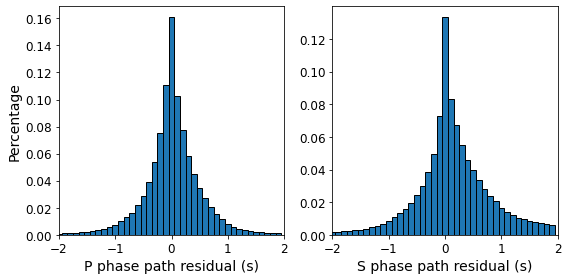

In [8]:
# 绘制残差分布图
# plot residual distrubution
counts, bins = np.histogram(P_res_list,bins=np.arange(-2.05,2.05,0.1))
counts = counts/(len(P_res_list))
plt.figure(figsize=(8,4))
plt.subplot(121)
counts, bins = np.histogram(P_res_list,bins=np.arange(-2.05,2.05,0.1))
counts = counts/(len(P_res_list))
plt.hist(bins[:-1], bins, weights=counts, edgecolor='k')
plt.ylabel('Percentage',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-2,2])
plt.xlabel('P phase path residual (s)',fontsize=14)
plt.subplot(122)
counts, bins = np.histogram(S_res_list,bins=np.arange(-2.05,2.05,0.1))
counts = counts/(len(S_res_list))
plt.hist(bins[:-1], bins, weights=counts, edgecolor='k')
plt.xlabel('S phase path residual (s)',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-2,2])
plt.tight_layout()
plt.savefig('./imgs/DiTingResidualImg1215.png',dpi=1200)
plt.savefig('./imgs/DiTingResidualImg1215.eps',dpi=1200)
plt.show()
plt.close()

In [9]:
# 统计方位角和极性信息并绘制
# plot azimuth and first-motion polarity

# get az
az_list = list()
for t_az in list(DiTing_330km_csv['baz']):
    try:
        az_list.append(float(t_az))
    except:
        pass

motion_dict = dict()

motion_dict['U_I'] = 0
motion_dict['R_I'] = 0
motion_dict['D_I'] = 0
motion_dict['C_I'] = 0

motion_dict['U_E'] = 0
motion_dict['R_E'] = 0
motion_dict['D_E'] = 0
motion_dict['C_E'] = 0

motion_dict['U_-'] = 0
motion_dict['R_-'] = 0
motion_dict['D_-'] = 0
motion_dict['C_-'] = 0

for loc_dx in range(len(DiTing_330km_csv)):
    if loc_dx % 10000 == 0:
        print(loc_dx)
    t_line = DiTing_330km_csv.iloc[loc_dx]
    if t_line['p_motion'] == 'D':
        if t_line['p_clarity'] == 'I':
            motion_dict['D_I'] += 1
        elif  t_line['p_clarity'] == 'E':
            motion_dict['D_E'] += 1
        else:
            motion_dict['D_-'] += 1
            
    elif t_line['p_motion'] == 'U':
        if t_line['p_clarity'] == 'I':
            motion_dict['U_I'] += 1
        elif  t_line['p_clarity'] == 'E':
            motion_dict['U_E'] += 1
        else:
            motion_dict['U_-'] += 1
            
    elif t_line['p_motion'] == 'C':
        if t_line['p_clarity'] == 'I':
            motion_dict['C_I'] += 1
        elif  t_line['p_clarity'] == 'E':
            motion_dict['C_E'] += 1
        else:
            motion_dict['C_-'] += 1
            
    elif t_line['p_motion'] == 'R':
        if t_line['p_clarity'] == 'I':
            motion_dict['R_I'] += 1
            
        elif  t_line['p_clarity'] == 'E':
            motion_dict['R_E'] += 1
        else:
            motion_dict['R_-'] += 1
    else:
        pass

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
13

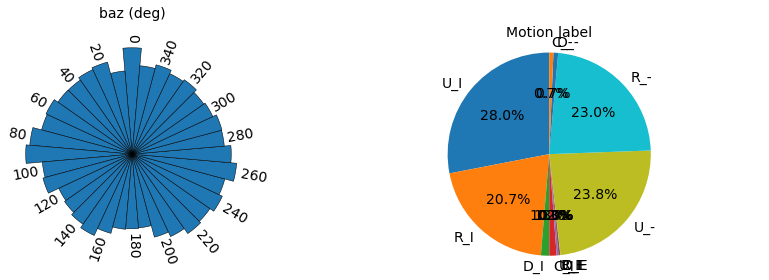

In [10]:
az_histgram = np.histogram(az_list,bins=np.arange(0,361,10))
# set figure size
plt.figure(figsize=(12,4))

# plot polar axis
ax = plt.subplot(121, polar=True)

# remove grid
plt.axis('off')

# Set the coordinates limits
upperLimit = az_histgram[0].max()
lowerLimit = az_histgram[0].min()

# Compute max and min in the dataset
max = az_histgram[0].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
#heights = np.log10(az_histgram[0])
heights = az_histgram[0]
# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(az_histgram[0])

# Compute the angle each bar is centered on:
indexes = list(range(1, len(az_histgram[1][:-1])+1))
angles = [((element-1) * width) +  0.5*np.pi for element in indexes] 

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=1,
    linewidth=0.5, 
    edgecolor="black")

# little space between the bar and the label
labelPadding = 30.0

# Add labels
gap = 0
for bar, angle, height, label in zip(bars, angles, heights, az_histgram[1][:-1]):
    
    if gap%2 == 0:
        gap += 1
    else:
        gap += 1
        continue
        
    
    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y= bar.get_height()*1.05, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor",fontsize=14) 

plt.title('baz (deg)',fontsize=14)

# plot polar axis
plt.subplot(122)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = list(motion_dict.keys()) 
sizes = list(motion_dict.values())
#colors = ['orangered', 'saddlebrown', 'gold', 'darkblue', 'gold', 'deeppink']
#explode = (0, 0, 0, 0, 0, 0 ,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize':14})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Motion label',fontsize=14)

plt.tight_layout()
plt.savefig('./imgs/DiTingAzi_Motion_bbox_tight_1215.eps',format='eps',dpi=1200,bbox_inches='tight')
plt.savefig('./imgs/DiTingAzi_Motion_bbox_tight_1215.png',format='png',dpi=1200,bbox_inches='tight')
plt.show()
plt.close()

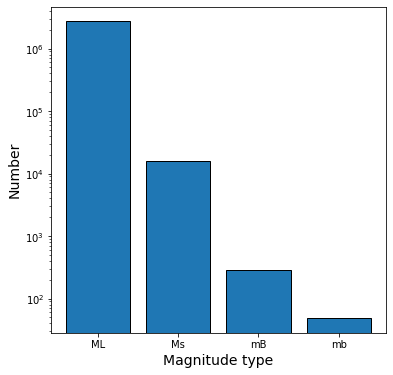

In [11]:
# plot mag type
Mag_list = Counter(list(DiTing_330km_csv['mag_type']))
Mag_list['ML'] += Mag_list['Ml']
del Mag_list['Ml']
Mag_list['Ms'] += Mag_list['MS']
del Mag_list['MS']
plt.figure(figsize=(6,6))
plt.bar(Mag_list.keys(), Mag_list.values(),log=True, edgecolor='k')
plt.xlabel('Magnitude type',fontsize=14)
plt.ylabel('Number',fontsize=14)
plt.savefig('./imgs/Mag_bar.png',dpi=1200)
plt.savefig('./imgs/Mag_bar.eps')
plt.show()
plt.close()

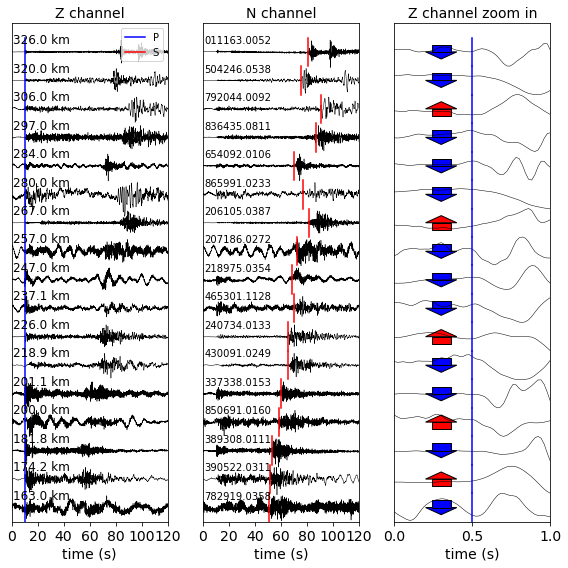

In [12]:
data_list = list()
meta_data_list = list()
dis_bins = np.arange(160,331,10)

for dis_dx in range(len(dis_bins)-1):
    sub_csv = DiTing_330km_csv.loc[(DiTing_330km_csv.dis > dis_bins[dis_dx]) & (DiTing_330km_csv.dis <= dis_bins[dis_dx+1])]
    sub_csv = sub_csv.loc[(sub_csv.p_motion == 'U') | (sub_csv.p_motion == 'D') | (sub_csv.p_motion == 'C') | (sub_csv.p_motion == 'R')]
    random_line = sub_csv.iloc[np.random.choice(len(sub_csv))]
    part = random_line['part']
    key = random_line['key']
    key_correct = key.split('.')
    key = key_correct[0].rjust(6,'0') + '.' + key_correct[1].ljust(4,'0')
    p_t = (random_line['p_pick'])*2
    s_t = (random_line['s_pick'])*2
    data = get_from_DiTing(part=part, key=key, h5file_path=DiTingDatasetPath)
    data_list.append(data)
    meta_data_list.append(random_line)

plt.figure(figsize=(8,8))
for subplot_dx in range(1,4):
    plt.subplot(1,3,subplot_dx)
    if subplot_dx == 1:
        plt.title('Z channel',fontsize=14)
    elif subplot_dx == 2:
        plt.title('N channel',fontsize=14)
    elif subplot_dx == 3:
        plt.title('Z channel zoom in',fontsize=14)
    plt.xlabel('time (s)',fontsize=14)
    
    if subplot_dx == 3:
        plt.xticks(np.arange(0,51,25),np.arange(0,1.01,0.5),fontsize=14)
    else:
        plt.xticks(np.arange(0,6100,1000),np.arange(0,121,20),fontsize=14)
    plt.yticks([])
    plot_dx = 0
    for data_dx,data in enumerate(data_list):
        # move trace to have better visiualization
        p_t = meta_data_list[data_dx]['p_pick']*2
        t_norm_data = data[p_t-500:p_t+5500, subplot_dx-1] - np.mean(data[p_t-500:p_t+2500, subplot_dx-1])
        t_norm_data /= np.max(t_norm_data)*1.2
        dis = (meta_data_list[data_dx]['dis'])
        p_t = 500
        s_t = 500 + meta_data_list[data_dx]['s_pick']*2 - meta_data_list[data_dx]['p_pick']*2 
        if subplot_dx == 3:
            p_t = meta_data_list[data_dx]['p_pick']*2 
            motion_plot_data = data[p_t-25:p_t+26, 0]
            motion_plot_data -= np.mean(motion_plot_data)
            motion_plot_data /= np.max(np.abs(motion_plot_data))
            plt.plot(motion_plot_data + plot_dx*2.0, color='k',linewidth=0.5)
        else:
            plt.plot(t_norm_data + plot_dx*2.0, color='k',linewidth=0.5)
        
        key = meta_data_list[data_dx]['key']
        key_correct = key.split('.')
        key = key_correct[0].rjust(6,'0') + '.' + key_correct[1].ljust(4,'0')
        
        if  meta_data_list[data_dx]['p_motion'] == 'U' or meta_data_list[data_dx]['p_motion'] == 'C':
            motion = 'Up'
        elif meta_data_list[data_dx]['p_motion'] == 'R' or meta_data_list[data_dx]['p_motion'] == 'D':
            motion = 'Down'
        else:
            print('Motion error')
        
        if subplot_dx == 1:
            plt.text(50, plot_dx*2.0+0.6, '{:.1f} km'.format(dis),fontsize=12)

                
        if subplot_dx == 2:
            plt.text(50, plot_dx*2.0+0.6, '{:}'.format(key[:]),fontsize=10)
            
        if subplot_dx == 1 and data_dx == 0:
            plt.plot([0,0],[0,0],color='b',label='P')
            plt.plot([0,0],[0,0],color='r',label='S')
            plt.legend(loc='upper right')
        if subplot_dx == 3:
            
            center_x = 15
            left_x = center_x - 5
            right_x = center_x + 5
            bar_half_with = 8
            if motion == 'Up':
                # custom arrow
                t = plt.Polygon([[center_x,plot_dx*2.0+0.5], [left_x,plot_dx*2.0], [right_x, plot_dx*2.0]], edgecolor='k',facecolor='r')
                plt.gca().add_patch(t)
                t = plt.Polygon([[left_x+bar_half_with,plot_dx*2.0], [right_x-bar_half_with, plot_dx*2.0],[right_x-bar_half_with, plot_dx*2.0-0.5],[left_x+bar_half_with,plot_dx*2.0-0.5]], edgecolor='k',facecolor='r')
                plt.gca().add_patch(t)
            else:
                t = plt.Polygon([[center_x,plot_dx*2.0-0.5], [left_x,plot_dx*2.0], [right_x, plot_dx*2.0]], edgecolor='k',facecolor='b')
                plt.gca().add_patch(t)
                t = plt.Polygon([[left_x+bar_half_with,plot_dx*2.0], [right_x-bar_half_with, plot_dx*2.0],[right_x-bar_half_with, plot_dx*2.0+0.5],[left_x+bar_half_with,plot_dx*2.0+0.5]], edgecolor='k',facecolor='b')
                plt.gca().add_patch(t)
                
        if subplot_dx == 1:
            plt.plot([p_t,p_t],[plot_dx*2.0-1.0,plot_dx*2.0+1.0],color='b')
        elif subplot_dx == 2:
            plt.plot([s_t,s_t],[plot_dx*2.0-1.0,plot_dx*2.0+1.0],color='r')
        else:
            plt.plot([25,25],[plot_dx*2.0-1.0,plot_dx*2.0+1.0],color='b')
            
        plot_dx += 1
    if subplot_dx == 3:
        plt.ylim([-1,34])
        plt.xlim([0,50])
    else:
        plt.ylim([-1,34])
        plt.xlim([0,6000])
plt.tight_layout()
plt.show()
plt.close()

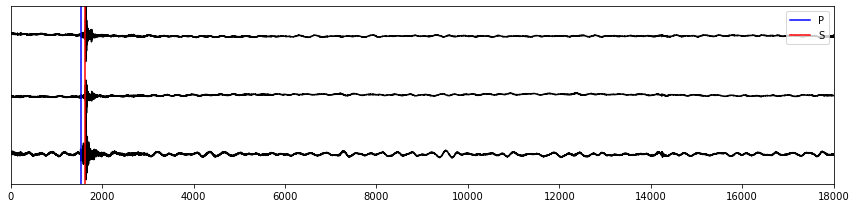

In [13]:
# check waveform and label
random_id = np.random.randint(len(DiTingDatasetPath))
random_line = DiTing_330km_csv.iloc[random_id]
part = random_line['part']
key = random_line['key']
p_t = int(random_line['p_pick']*2)
s_t = int(random_line['s_pick']*2)
waveform = get_from_DiTing(part=part, key=key, h5file_path=DiTingDatasetPath)
plt.figure(figsize=(12,3))
for chdx in range(3):
    temp_plot = waveform[:,chdx] 
    temp_plot -= np.mean(temp_plot)
    temp_plot /= np.max(np.abs(temp_plot))
    plt.plot(temp_plot + chdx*2, color='k' )
    
plt.plot([p_t,p_t],[-1,5],color='b',label='P')
plt.plot([s_t,s_t],[-1,5],color='r',label='S')
plt.ylim([-1,5])
plt.xlim([0,waveform.shape[0]])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

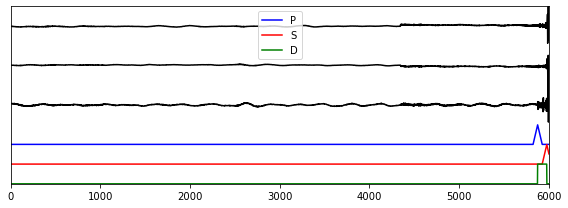

In [14]:
# shift augmentation
temp_X, temp_Y = get_shifted_instance_for_EqDetPhasePicking_training(dataset_name='DiTing',
                                                                     dataset_path=DiTingDatasetPath,
                                                                     part=part,
                                                                     key = key,
                                                                     data_length=9000,P=p_t,S=s_t)

plt.figure(figsize=(8,3))
for chdx in range(3):
    temp_plot = temp_X[:,chdx] 
    temp_plot -= np.mean(temp_plot)
    temp_plot /= np.max(np.abs(temp_plot))
    plt.plot(temp_plot + chdx*2, color='k' )

plt.plot(temp_Y[:,0] - 2, color='b', label='P' )
plt.plot(temp_Y[:,1] - 3, color='r', label='S' )
plt.plot(temp_Y[:,2] - 4, color='g', label='D' )
plt.ylim([-4,5])
plt.xlim([0,6000])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

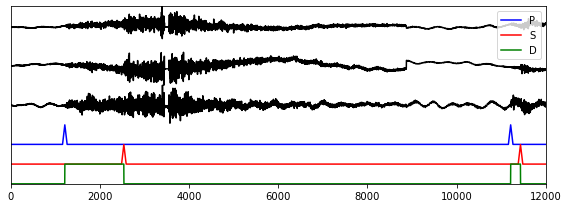

In [15]:
total_lines = len(DiTing_330km_csv)
choice_ids = np.random.choice(total_lines, 8)

data_length = 12000
key_list = list()
part_list = list()
P_list = list()
S_list = list()

for choice_id in choice_ids:
    choice_line = DiTing_330km_csv.iloc[choice_id]
    key = choice_line['key']
    part = choice_line['part']
    p_t = choice_line['p_pick']*2
    s_t = choice_line['s_pick']*2

    key_list.append(key)
    part_list.append(part)
    P_list.append(p_t)
    S_list.append(s_t)

temp_X, temp_Y = get_augmented_instance_for_EqDetPhasePicking_training(dataset_name='DiTing',
                                                                     dataset_path=DiTingDatasetPath,
                                                                     data_length=data_length,
                                                                     key_list = key_list,
                                                                     temp_part_list = part_list,
                                                                     P_list = P_list,
                                                                     S_list = S_list)

plt.figure(figsize=(8,3))
for chdx in range(3):
    temp_plot = temp_X[:,chdx] 
    temp_plot -= np.mean(temp_plot)
    temp_plot /= np.max(np.abs(temp_plot))
    plt.plot(temp_plot + chdx*2, color='k' )

plt.plot(temp_Y[:,0] - 2, color='b', label='P' )
plt.plot(temp_Y[:,1] - 3, color='r', label='S' )
plt.plot(temp_Y[:,2] - 4, color='g', label='D' )
plt.ylim([-4,5])
plt.xlim([0,data_length])
plt.yticks([])
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
plt.close()

# STEAD dataset 
# STEAD 数据集
https://github.com/smousavi05/STEAD

In [16]:
# 在此修改数据集路径
# change path here
STEAD_DatasetPath = '/mnt/GPT_disk/DL_datasets/STEAD/waveforms.hdf5'
# 加载数据集CSV文件
# load csv file
STEAD_csv = pd.read_csv('/mnt/GPT_disk/DL_datasets/STEAD/metadata_eq.csv')
# CSV文件各列信息
# show columns in CSV file
print('Csv Index Info:')
print(STEAD_csv.keys())

/public/home/zhaoming/guochang/miniconda3/envs/DiTingDevEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Csv Index Info:
Index(['Unnamed: 0', 'network_code', 'receiver_code', 'receiver_type',
       'receiver_latitude', 'receiver_longitude', 'receiver_elevation_m',
       'p_arrival_sample', 'p_status', 'p_weight', 'p_travel_sec',
       's_arrival_sample', 's_status', 's_weight', 'source_id',
       'source_origin_time', 'source_origin_uncertainty_sec',
       'source_latitude', 'source_longitude', 'source_error_sec',
       'source_gap_deg', 'source_horizontal_uncertainty_km', 'source_depth_km',
       'source_depth_uncertainty_km', 'source_magnitude',
       'source_magnitude_type', 'source_magnitude_author',
       'source_mechanism_strike_dip_rake', 'source_distance_deg',
       'source_distance_km', 'back_azimuth_deg', 'snr_db', 'coda_end_sample',
       'trace_start_time', 'trace_category', 'trace_name'],
      dtype='object')


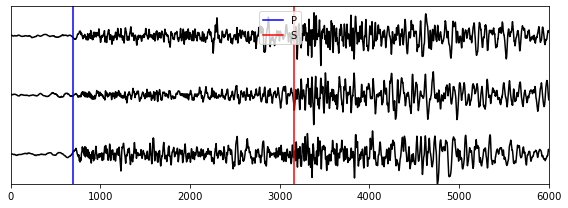

In [17]:
# check waveform and label
random_id = np.random.randint(len(STEAD_csv))
random_line = STEAD_csv.iloc[random_id]
key = random_line['trace_name']
p_t = int(random_line['p_arrival_sample'])
s_t = int(random_line['s_arrival_sample'])
waveform = get_from_STEAD(key=key, h5file_path=STEAD_DatasetPath)
plt.figure(figsize=(8,3))
for chdx in range(3):
    temp_plot = waveform[:,chdx] 
    temp_plot -= np.mean(temp_plot)
    temp_plot /= np.max(np.abs(temp_plot))
    plt.plot(temp_plot + chdx*2, color='k' )
    
plt.plot([p_t,p_t],[-1,5],color='b',label='P')
plt.plot([s_t,s_t],[-1,5],color='r',label='S')
plt.ylim([-1,5])
plt.xlim([0,6000])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

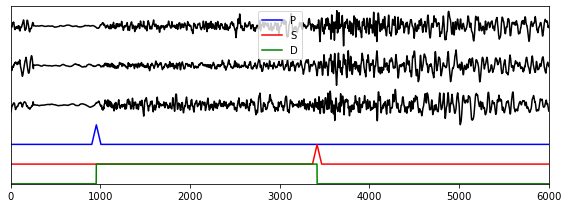

In [18]:
# shift augmentation
temp_X, temp_Y = get_shifted_instance_for_EqDetPhasePicking_training(dataset_name='STEAD',
                                                                     dataset_path=STEAD_DatasetPath,
                                                                     key = key,
                                                                     data_length=6000,P=p_t,S=s_t)

plt.figure(figsize=(8,3))
for chdx in range(3):
    temp_plot = temp_X[:,chdx] 
    temp_plot -= np.mean(temp_plot)
    temp_plot /= np.max(np.abs(temp_plot))
    plt.plot(temp_plot + chdx*2, color='k' )

plt.plot(temp_Y[:,0] - 2, color='b', label='P' )
plt.plot(temp_Y[:,1] - 3, color='r', label='S' )
plt.plot(temp_Y[:,2] - 4, color='g', label='D' )
plt.ylim([-4,5])
plt.xlim([0,6000])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

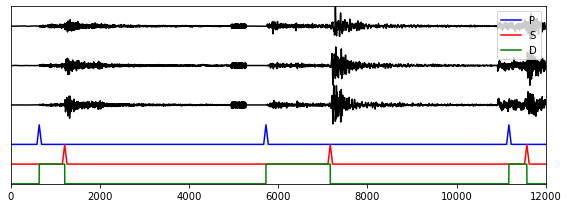

In [19]:
total_lines = len(STEAD_csv)
choice_ids = np.random.choice(total_lines, 8)

data_length = 12000
key_list = list()
P_list = list()
S_list = list()

for choice_id in choice_ids:
    choice_line = STEAD_csv.iloc[choice_id]
    key = choice_line['trace_name']
    p_t = choice_line['p_arrival_sample']
    s_t = choice_line['s_arrival_sample']

    key_list.append(key)
    P_list.append(p_t)
    S_list.append(s_t)

temp_X, temp_Y = get_augmented_instance_for_EqDetPhasePicking_training(dataset_name='STEAD',
                                                                     dataset_path=STEAD_DatasetPath,
                                                                     data_length=data_length,
                                                                     key_list = key_list,
                                                                     P_list = P_list,
                                                                     S_list = S_list)

plt.figure(figsize=(8,3))
for chdx in range(3):
    temp_plot = temp_X[:,chdx] 
    temp_plot -= np.mean(temp_plot)
    temp_plot /= np.max(np.abs(temp_plot))
    plt.plot(temp_plot + chdx*2, color='k' )

plt.plot(temp_Y[:,0] - 2, color='b', label='P' )
plt.plot(temp_Y[:,1] - 3, color='r', label='S' )
plt.plot(temp_Y[:,2] - 4, color='g', label='D' )
plt.ylim([-4,5])
plt.xlim([0,data_length])
plt.yticks([])
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
plt.close()

In [20]:
STEAD_csv_noise_csv = pd.read_csv('/mnt/GPT_disk/DL_datasets/STEAD/metadata_no.csv')
# CSV文件各列信息
# show columns in CSV file
print('Csv Index Info:')
print(STEAD_csv_noise_csv.keys())

Csv Index Info:
Index(['Unnamed: 0', 'network_code', 'receiver_code', 'receiver_type',
       'receiver_latitude', 'receiver_longitude', 'receiver_elevation_m',
       'p_arrival_sample', 'p_status', 'p_weight', 'p_travel_sec',
       's_arrival_sample', 's_status', 's_weight', 'source_id',
       'source_origin_time', 'source_origin_uncertainty_sec',
       'source_latitude', 'source_longitude', 'source_error_sec',
       'source_gap_deg', 'source_horizontal_uncertainty_km', 'source_depth_km',
       'source_depth_uncertainty_km', 'source_magnitude',
       'source_magnitude_type', 'source_magnitude_author',
       'source_mechanism_strike_dip_rake', 'source_distance_deg',
       'source_distance_km', 'back_azimuth_deg', 'snr_db', 'coda_end_sample',
       'trace_start_time', 'trace_category', 'trace_name'],
      dtype='object')


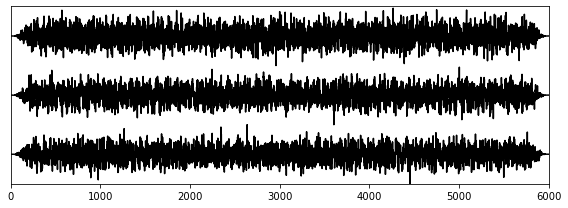

In [21]:
# check waveform and label
random_id = np.random.randint(len(STEAD_csv_noise_csv))
random_line = STEAD_csv_noise_csv.iloc[random_id]
key = random_line['trace_name']
p_t = random_line['p_arrival_sample']
s_t = random_line['s_arrival_sample']
waveform = get_from_STEAD(key=key, h5file_path=STEAD_DatasetPath, is_noise=True)
plt.figure(figsize=(8,3))
for chdx in range(3):
    temp_plot = waveform[:,chdx] 
    temp_plot -= np.mean(temp_plot)
    temp_plot /= np.max(np.abs(temp_plot))
    plt.plot(temp_plot + chdx*2, color='k' )
plt.ylim([-1,5])
plt.xlim([0,6000])
plt.yticks([])
plt.tight_layout()
plt.show()
plt.close()

# INSTANCE dataset
# INSTANCE 数据集
http://www.pi.ingv.it/banche-dati/instance/

In [14]:
# 在此修改数据集路径
# change path here
INSTANCE_DatasetPath = '/mnt/GPT_disk/DL_datasets/INSTANCE/Instance_events_counts.hdf5'
# 加载数据集CSV文件
# load csv file
INSTANCE_csv = pd.read_csv('/mnt/GPT_disk/DL_datasets/INSTANCE/metadata_Instance_events_both_p_s.csv')
# CSV文件各列信息
# show columns in CSV file
print('Csv Index Info:')
print(INSTANCE_csv.keys())

/public/home/zhaoming/guochang/miniconda3/envs/DiTingDevEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (24,25,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Csv Index Info:
Index(['Unnamed: 0', 'source_id', 'station_network_code', 'station_code',
       'station_location_code', 'station_channels', 'station_latitude_deg',
       'station_longitude_deg', 'station_elevation_m', 'station_vs_30_mps',
       ...
       'trace_sa10_cmps2', 'trace_sa30_cmps2', 'trace_name',
       'trace_GPD_P_number', 'trace_GPD_S_number',
       'trace_EQT_number_detections', 'trace_EQT_P_number',
       'trace_EQT_S_number', 'trace_deconvolved_units', 'source_type'],
      dtype='object', length=116)


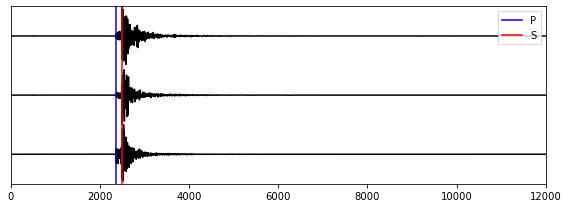

In [24]:
## check waveform and label
random_id = np.random.randint(len(INSTANCE_csv))
random_line = INSTANCE_csv.iloc[random_id]
key = random_line['trace_name']
p_t = random_line['trace_P_arrival_sample']
s_t = random_line['trace_S_arrival_sample']
waveform = get_from_INSTANCE(key=key, h5file_path=INSTANCE_DatasetPath)
plt.figure(figsize=(8,3))
for chdx in range(3):
    temp_plot = waveform[:,chdx] 
    temp_plot -= np.mean(temp_plot)
    temp_plot /= np.max(np.abs(temp_plot))
    plt.plot(temp_plot + chdx*2, color='k' )

plt.plot([p_t,p_t],[-1,5],color='b',label='P')
plt.plot([s_t,s_t],[-1,5],color='r',label='S')
plt.ylim([-1,5])
plt.xlim([0,12000])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [25]:
INSTANCE_noise_csv = pd.read_csv('/mnt/GPT_disk/DL_datasets/INSTANCE/metadata_Instance_noise.csv')
INSTANCE_noise_DatasetPath = '/mnt/GPT_disk/DL_datasets/INSTANCE/Instance_noise.hdf5'

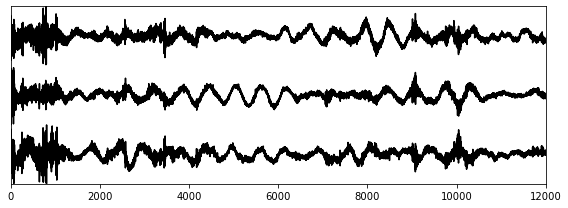

In [26]:
## check waveform and label
random_id = np.random.randint(len(INSTANCE_noise_csv))
random_line = INSTANCE_noise_csv.iloc[random_id]
key = random_line['trace_name']
waveform = get_from_INSTANCE(key=key, h5file_path=INSTANCE_noise_DatasetPath)
plt.figure(figsize=(8,3))
for chdx in range(3):
    temp_plot = waveform[:,chdx] 
    temp_plot -= np.mean(temp_plot)
    temp_plot /= np.max(np.abs(temp_plot))
    plt.plot(temp_plot + chdx*2, color='k' )
plt.ylim([-1,5])
plt.xlim([0,12000])
plt.yticks([])
plt.tight_layout()
plt.show()
plt.close()

# Det & Pick TFDataset Visualization
# 地震检测与震相拾取数据集可视化

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import tensorflow as tf
import yaml
# load configs
cfgs = yaml.load(open('../example_configs/det_pick_0718.yaml','r'),Loader=yaml.Loader)

## Seperate TFDataset level

In [ ]:
duplicate_num = cfgs['Training']['Model']['duplicate_num']
model_input_length = cfgs['Training']['Model']['input_length']
model_input_channel = cfgs['Training']['Model']['input_channel']

training_dict_list = []
training_weight_list = []

validation_dict_list = []
validation_weight_list = []

label_type_dict = dict()
label_shape_dict = dict()

for class_dx in range(cfgs['Training']['Model']['n_classes']):
    for dup_dx in range(duplicate_num):
        label_type_dict['C{}D{}'.format(class_dx,dup_dx)] = tf.float32
        label_shape_dict['C{}D{}'.format(class_dx,dup_dx)] = (cfgs['Training']['Model']['input_length'], 1)

for dataset_key in cfgs['Training']['Datasets']:
    t_dict = cfgs['Training']['Datasets'][dataset_key]
    t_dict['csv_path'] = t_dict['train_csv_path']
    t_dict['hdf5_path'] = t_dict['train_hdf5_path']
    t_dict['duplicate_num'] = duplicate_num

    if t_dict['has_parts'] is True:
        t_dict['part_list'] = [t_dict['hdf5_path'].format(i) for i in range(t_dict['part_num'])]

    training_dict_list.append(t_dict)
    training_weight_list.append(float(t_dict['sample_weight']))

    if t_dict['has_validation'] is True:
        t_dict['csv_path'] = t_dict['val_csv_path']
        t_dict['hdf5_path'] = t_dict['val_hdf5_path']
        if t_dict['has_parts'] is True:
            t_dict['part_list'] = [t_dict['hdf5_path'].format(i) for i in range(t_dict['part_num'])]

    validation_dict_list.append(t_dict)
    validation_weight_list.append(float(t_dict['sample_weight']))

training_dataset_list = [tf.data.Dataset.from_generator(DiTingGenerator(training_dict_list[idx]),output_types = (tf.float32, label_type_dict), output_shapes = ( (model_input_length,model_input_channel), label_shape_dict)) for idx in range(len(training_dict_list))]
training_sample_dataset = tf.data.experimental.sample_from_datasets(training_dataset_list, weights=training_weight_list)

/public/home/zhaoming/guochang/miniconda3/envs/DiTingDevEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
batch_size = 32
for temp_dataset in training_dataset_list:
    for output_data in temp_dataset.batch(batch_size).take(1):
        for batch_dx in range(batch_size):
            plt.figure(figsize=(12,6))
            plt.plot(output_data[0].numpy()[batch_dx,:,0],color='k')
            plt.plot(output_data[0].numpy()[batch_dx,:,1] + 5,color='k')
            plt.plot(output_data[0].numpy()[batch_dx,:,2] + 10,color='k')

            plt.plot(output_data[1]['C0D0'][batch_dx,:,0] - 1,color='b')
            plt.plot(output_data[1]['C1D0'][batch_dx,:,0] - 2,color='r')
            plt.plot(output_data[1]['C2D0'][batch_dx,:,0] - 3,color='g')
            print(output_data[1]['C2D0'][batch_dx,:,0])
            plt.yticks([])
            plt.show()
            plt.close()

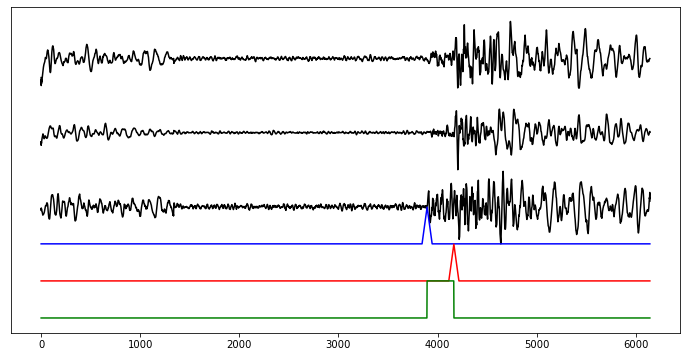

/tmp/ipykernel_37250/2293944931.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(output_data[0].numpy()[batch_dx,:,0]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,0])),color='k')


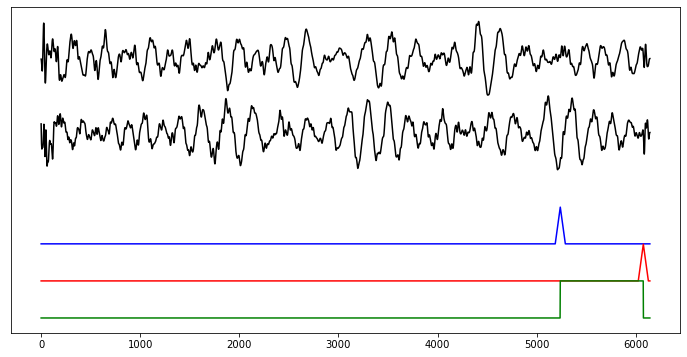

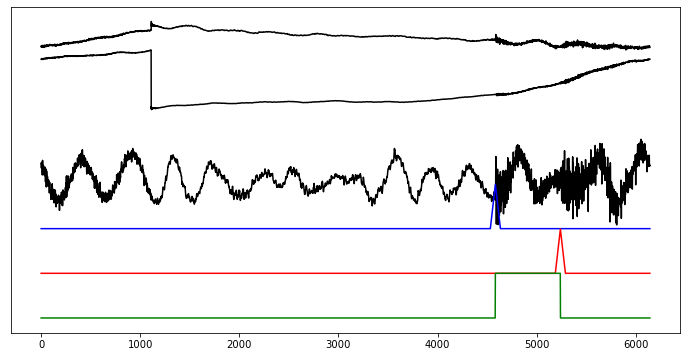

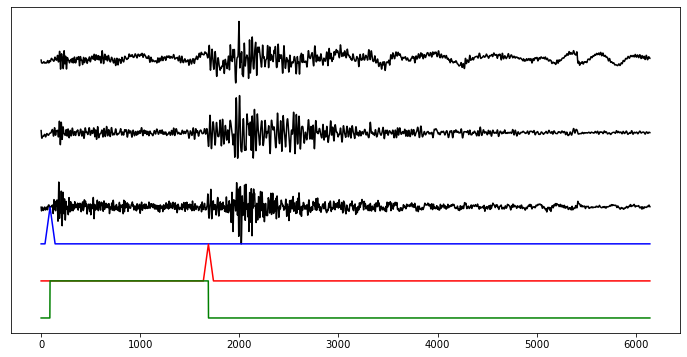

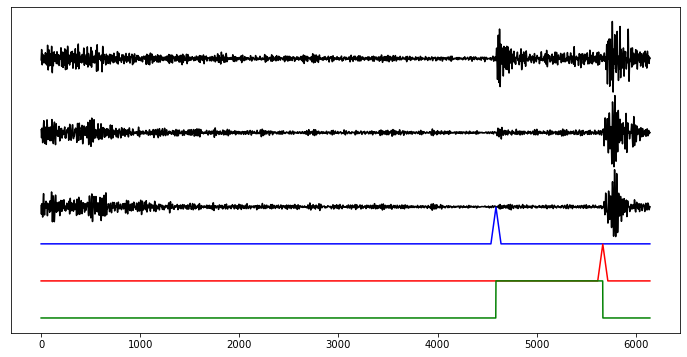

/tmp/ipykernel_37250/2293944931.py:8: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(output_data[0].numpy()[batch_dx,:,2]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,2])) + 4,color='k')


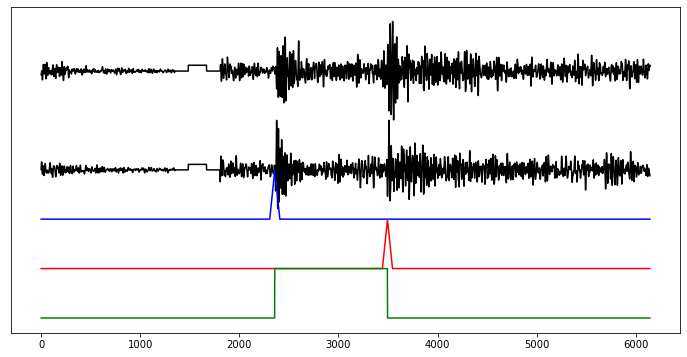

/tmp/ipykernel_37250/2293944931.py:7: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(output_data[0].numpy()[batch_dx,:,1]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,1])) + 2,color='k')


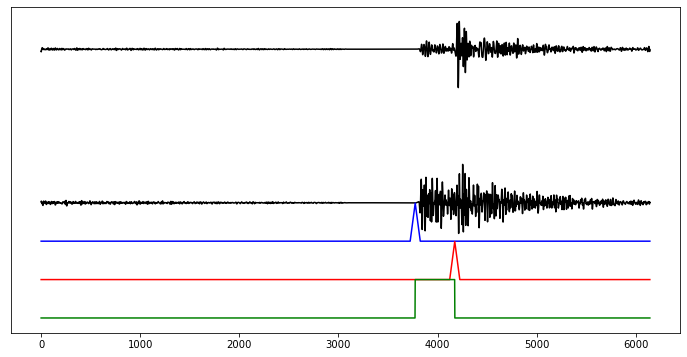

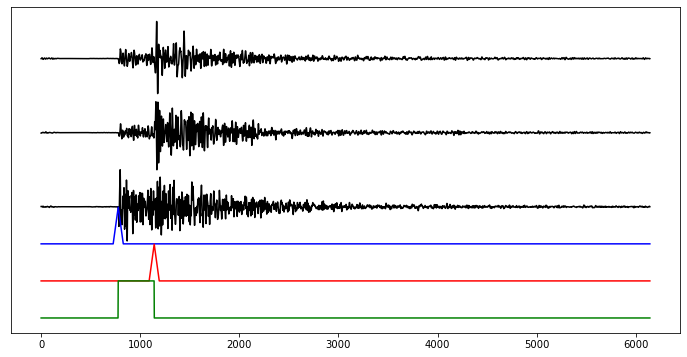

/tmp/ipykernel_37250/2293944931.py:7: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(output_data[0].numpy()[batch_dx,:,1]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,1])) + 2,color='k')


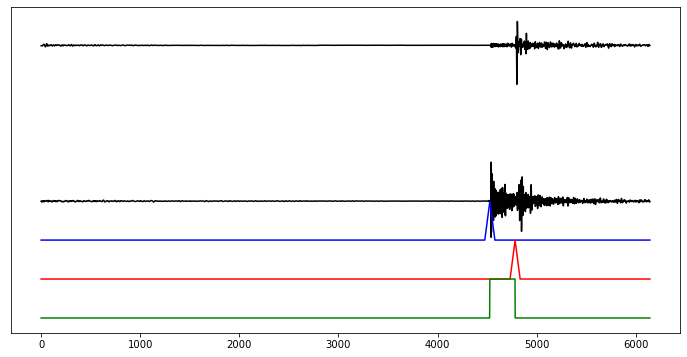

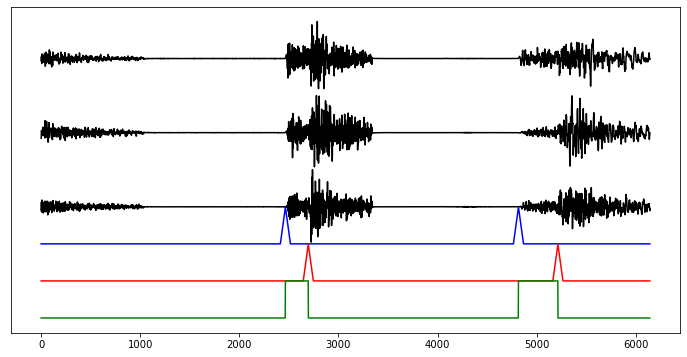

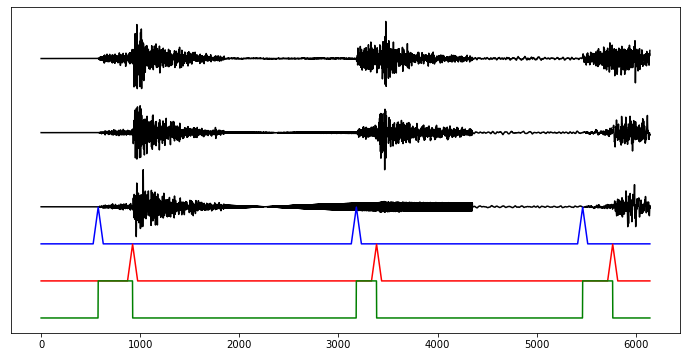

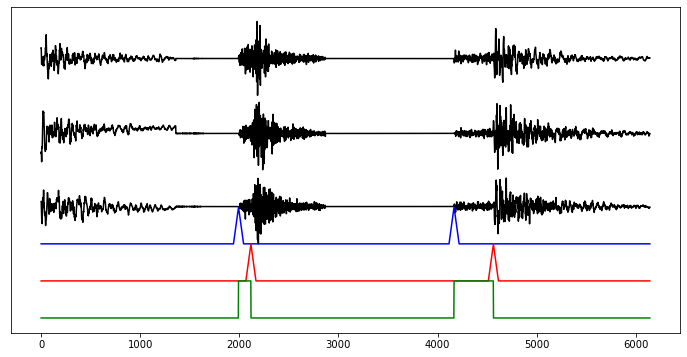

In [29]:
batch_size = 4
for temp_dataset in training_dataset_list:
    for output_data in temp_dataset.batch(batch_size).take(1):
        for batch_dx in range(batch_size):
            plt.figure(figsize=(12,6))
            plt.plot(output_data[0].numpy()[batch_dx,:,0]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,0])),color='k')
            plt.plot(output_data[0].numpy()[batch_dx,:,1]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,1])) + 2,color='k')
            plt.plot(output_data[0].numpy()[batch_dx,:,2]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,2])) + 4,color='k')

            plt.plot(output_data[1]['C0D0'][batch_dx,:,0] - 1,color='b')
            plt.plot(output_data[1]['C1D0'][batch_dx,:,0] - 2,color='r')
            plt.plot(output_data[1]['C2D0'][batch_dx,:,0] - 3,color='g')
            plt.yticks([])
            plt.show()
            plt.close()

In [30]:
noiseset_dict_list = list()
noiseset_weight_list = list()
for noiseset_key in cfgs['Training']['Noisesets']:
    t_dict = cfgs['Training']['Noisesets'][noiseset_key]
    t_dict['duplicate_num'] = duplicate_num
    t_dict['length'] = model_input_length
    noiseset_dict_list.append(t_dict)
    noiseset_weight_list.append(float(t_dict['sample_weight']))

real_negative_dataset_list = [tf.data.Dataset.from_generator(DiTingRealNoiseGenerator(noiseset_dict_list[idx]),output_types = (tf.float32, label_type_dict), output_shapes = ( (model_input_length,model_input_channel), label_shape_dict)) for idx in range(len(noiseset_dict_list))]
real_negative_dataset = tf.data.experimental.sample_from_datasets(real_negative_dataset_list, weights=noiseset_weight_list)

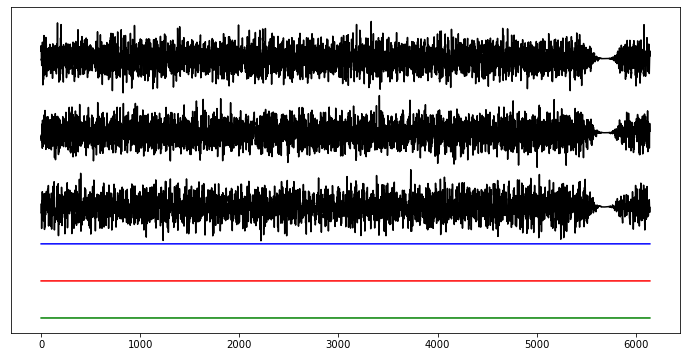

/tmp/ipykernel_37250/1056894413.py:7: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(output_data[0].numpy()[batch_dx,:,1]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,1])) + 2,color='k')


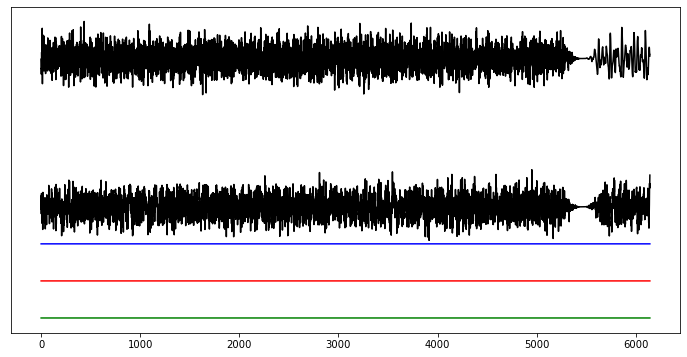

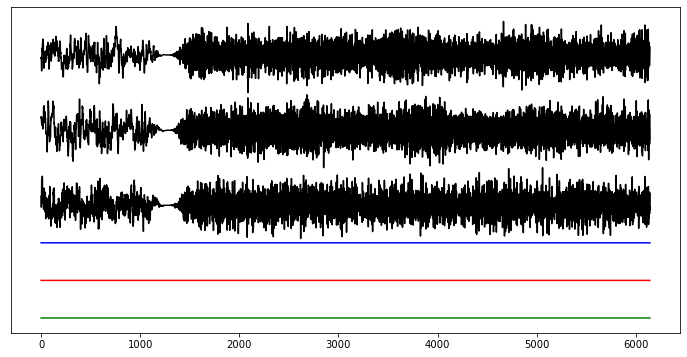

/tmp/ipykernel_37250/1056894413.py:7: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(output_data[0].numpy()[batch_dx,:,1]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,1])) + 2,color='k')


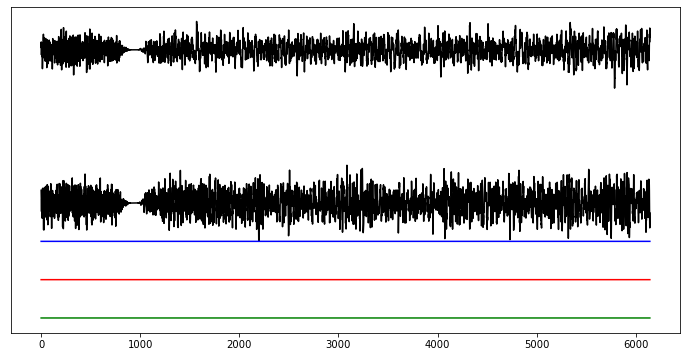

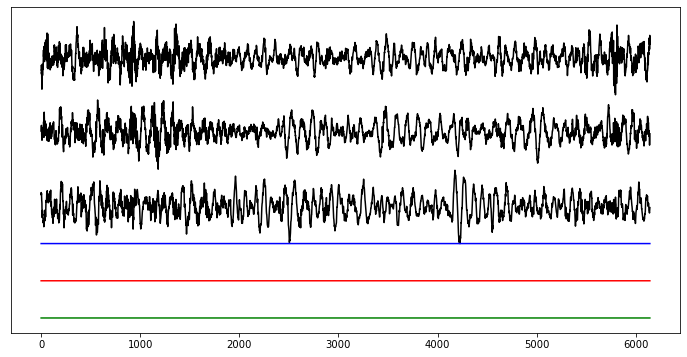

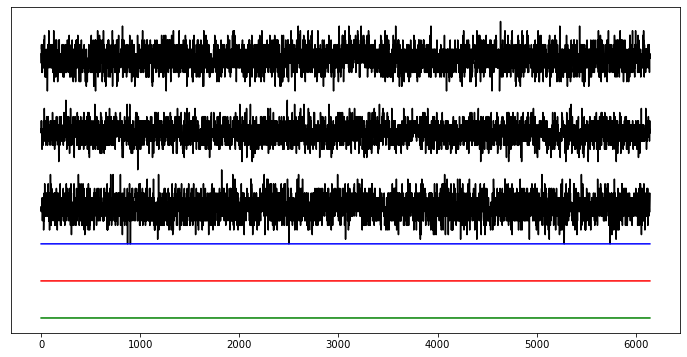

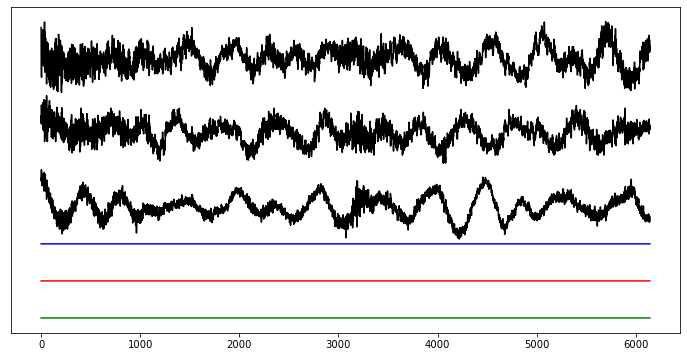

/tmp/ipykernel_37250/1056894413.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(output_data[0].numpy()[batch_dx,:,0]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,0])),color='k')


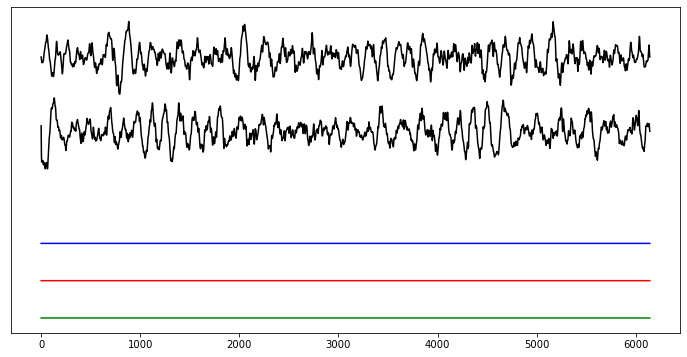

In [31]:
batch_size = 4
for temp_dataset in real_negative_dataset_list:
    for output_data in temp_dataset.batch(batch_size).take(1):
        for batch_dx in range(batch_size):
            plt.figure(figsize=(12,6))
            plt.plot(output_data[0].numpy()[batch_dx,:,0]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,0])),color='k')
            plt.plot(output_data[0].numpy()[batch_dx,:,1]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,1])) + 2,color='k')
            plt.plot(output_data[0].numpy()[batch_dx,:,2]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,2])) + 4,color='k')

            plt.plot(output_data[1]['C0D0'][batch_dx,:,0] - 1,color='b')
            plt.plot(output_data[1]['C1D0'][batch_dx,:,0] - 2,color='r')
            plt.plot(output_data[1]['C2D0'][batch_dx,:,0] - 3,color='g')
            plt.yticks([])
            plt.show()
            plt.close()

In [32]:
syn_negative_dataset = tf.data.Dataset.from_generator(DiTingSynNoiseGenerator(t_dict), output_types = (tf.float32, label_type_dict), output_shapes = ((model_input_length,model_input_channel), label_shape_dict))

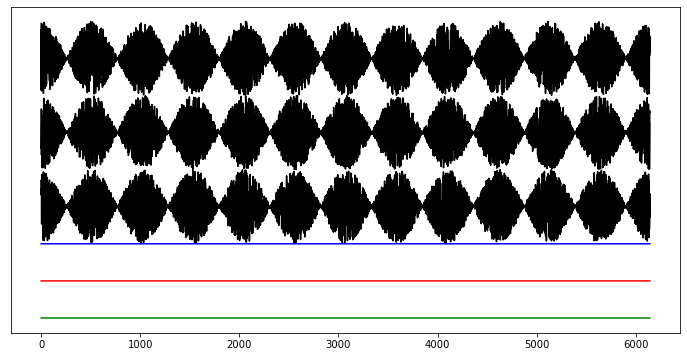

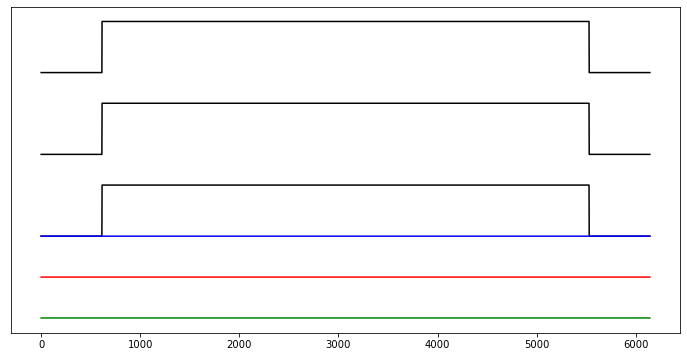

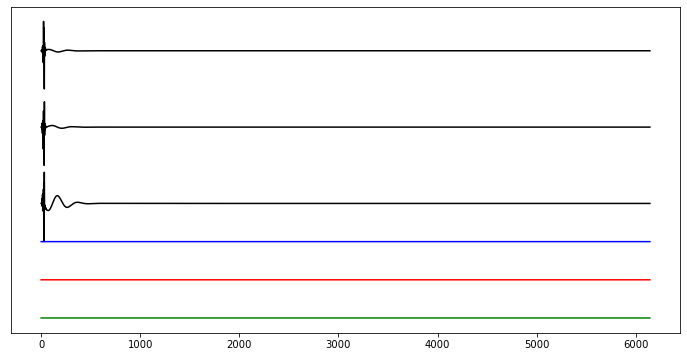

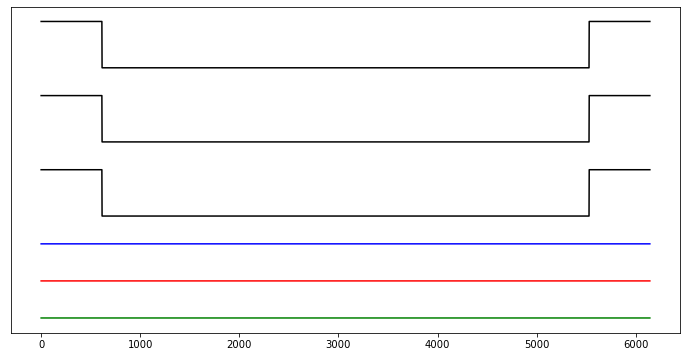

In [33]:
batch_size = 4
for output_data in syn_negative_dataset.batch(batch_size).take(1):
    for batch_dx in range(batch_size):
        plt.figure(figsize=(12,6))
        plt.plot(output_data[0].numpy()[batch_dx,:,0]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,0])),color='k')
        plt.plot(output_data[0].numpy()[batch_dx,:,1]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,1])) + 2,color='k')
        plt.plot(output_data[0].numpy()[batch_dx,:,2]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,2])) + 4,color='k')

        plt.plot(output_data[1]['C0D0'][batch_dx,:,0] - 1,color='b')
        plt.plot(output_data[1]['C1D0'][batch_dx,:,0] - 2,color='r')
        plt.plot(output_data[1]['C2D0'][batch_dx,:,0] - 3,color='g')
        plt.yticks([])
        plt.show()
        plt.close()

In [34]:
if len(validation_dict_list) >= 1:
    validation_dataset_list = [tf.data.Dataset.from_generator(DiTingGenerator(validation_dict_list[idx]),output_types = (tf.float32, label_type_dict), output_shapes = ( (validation_dict_list[idx]['length'],validation_dict_list[idx]['n_channels']), label_shape_dict)) for idx in range(len(validation_dict_list))]
    validation_sample_dataset = tf.data.experimental.sample_from_datasets(validation_dataset_list, weights=validation_weight_list)
else:
    validation_sample_dataset = None

# Final dataset level

In [35]:
final_training_sample_dataset = tf.data.experimental.sample_from_datasets([training_sample_dataset,real_negative_dataset,syn_negative_dataset], weights=[cfgs['Training']['trace_weight'], cfgs['Training']['real_noise_weight'],cfgs['Training']['syn_noise_weight']])
final_validation_sample_dataset = tf.data.experimental.sample_from_datasets([validation_sample_dataset, real_negative_dataset.repeat(),syn_negative_dataset.repeat()], weights=[cfgs['Training']['trace_weight'], cfgs['Training']['real_noise_weight'],cfgs['Training']['syn_noise_weight']])

/tmp/ipykernel_37250/1404336397.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(output_data[0].numpy()[batch_dx,:,1]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,1])) + 2,color='k')


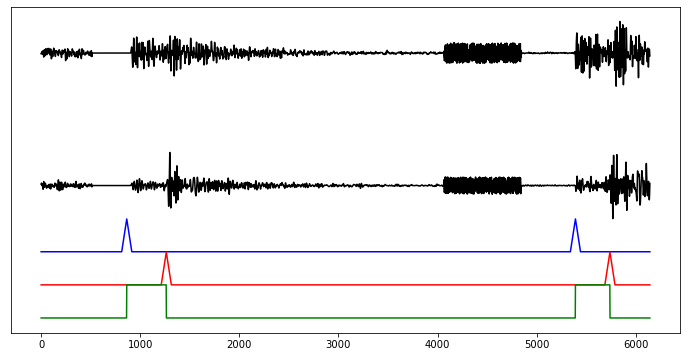

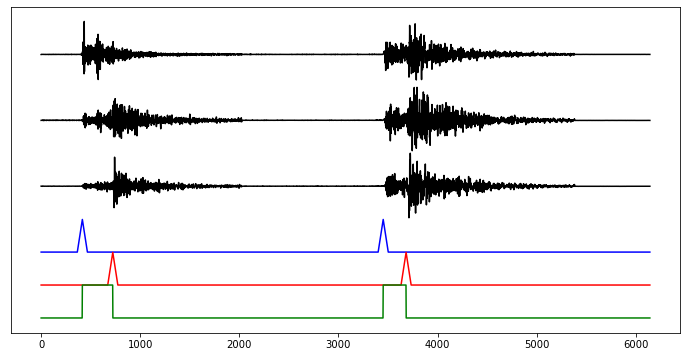

/tmp/ipykernel_37250/1404336397.py:7: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(output_data[0].numpy()[batch_dx,:,2]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,2])) + 4,color='k')


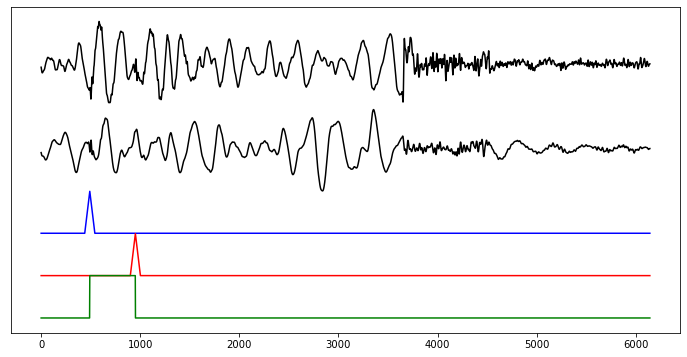

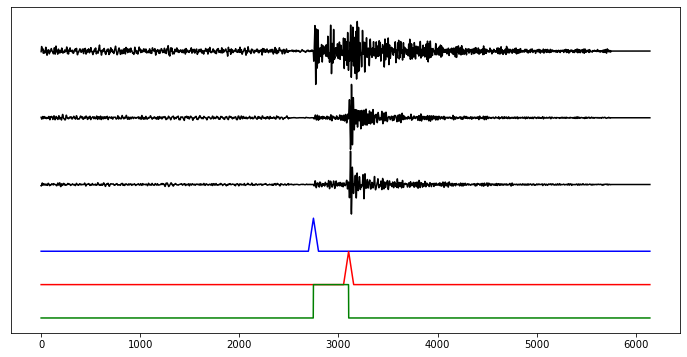

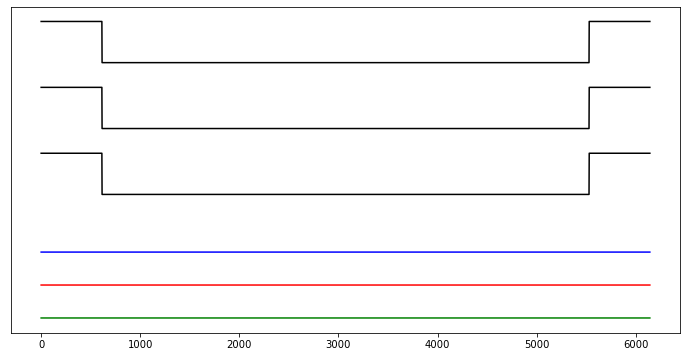

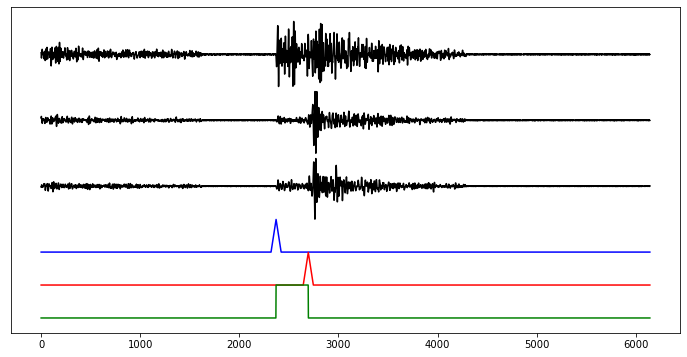

/tmp/ipykernel_37250/1404336397.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(output_data[0].numpy()[batch_dx,:,1]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,1])) + 2,color='k')


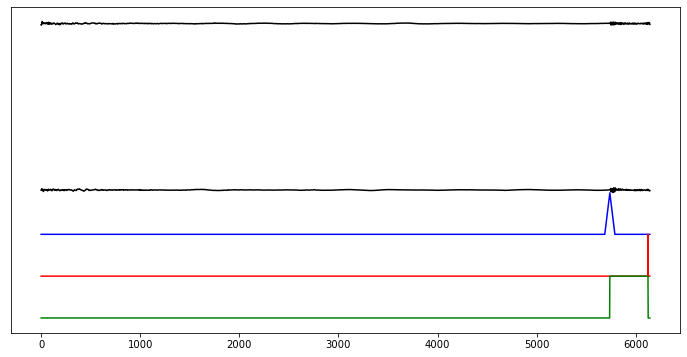

/tmp/ipykernel_37250/1404336397.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(output_data[0].numpy()[batch_dx,:,1]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,1])) + 2,color='k')


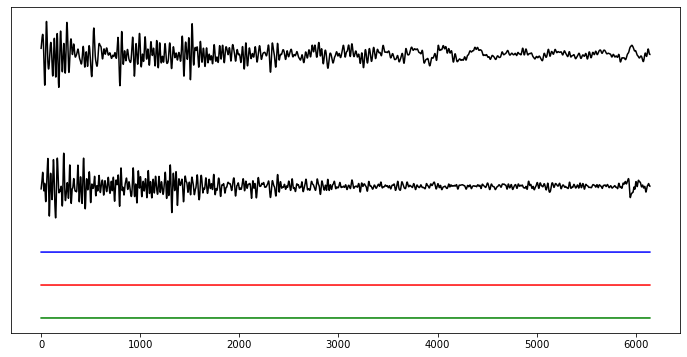

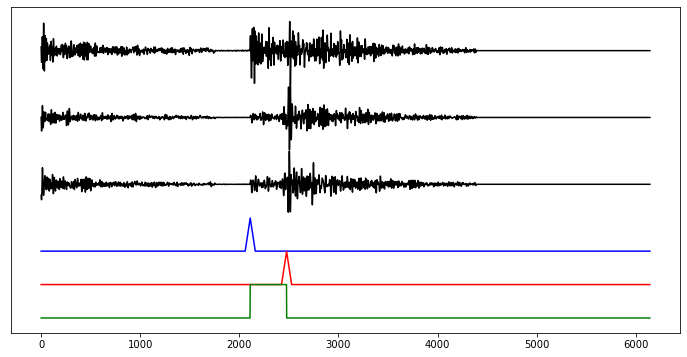

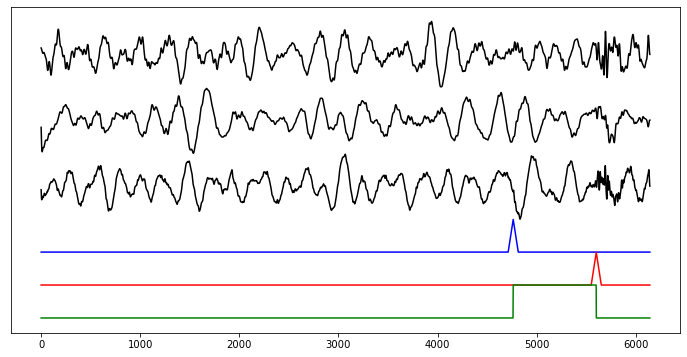

In [36]:
batch_size = 10
for output_data in final_training_sample_dataset.batch(batch_size).take(1):
    for batch_dx in range(batch_size):
        plt.figure(figsize=(12,6))
        plt.plot(output_data[0].numpy()[batch_dx,:,0]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,0])),color='k')
        plt.plot(output_data[0].numpy()[batch_dx,:,1]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,1])) + 2,color='k')
        plt.plot(output_data[0].numpy()[batch_dx,:,2]/np.max(np.abs(output_data[0].numpy()[batch_dx,:,2])) + 4,color='k')

        plt.plot(output_data[1]['C0D0'][batch_dx,:,0] - 2,color='b')
        plt.plot(output_data[1]['C1D0'][batch_dx,:,0] - 3,color='r')
        plt.plot(output_data[1]['C2D0'][batch_dx,:,0] - 4,color='g')
        plt.yticks([])
        plt.show()
        plt.close()

# FMP TFDataset Visualization
# 初动极性判别数据集可视化

In [37]:
from dtt.dev.fmp.data import get_instance_for_FirstMotionPolarity_training

## 谛听初动数据子集
## DiTing-FMP subset

In [38]:
# 在此修改数据集路径
# change path here
DiTingDatasetPath = '/mnt/GPT_disk/DL_datasets/DiTing330km_publish_50Hz/'
# 加载数据集CSV文件
# load csv file
DiTing_330km_csv = pd.read_csv(DiTingDatasetPath + 'DiTing330km_total.csv',dtype = {'key': str})
DiTing_motion_sub_csv = DiTing_330km_csv.loc[(DiTing_330km_csv.p_motion == 'U') | (DiTing_330km_csv.p_motion == 'D') | (DiTing_330km_csv.p_motion == 'C') | (DiTing_330km_csv.p_motion == 'R')]

/public/home/zhaoming/guochang/miniconda3/envs/DiTingDevEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (5,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


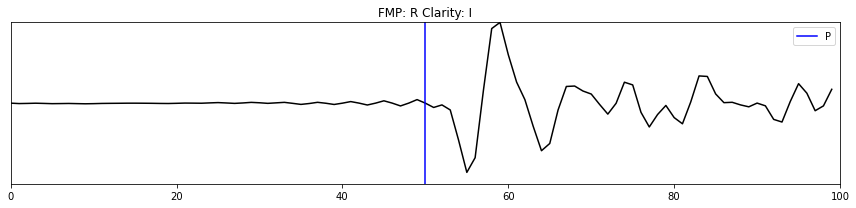

In [39]:
# check waveform and label
random_id = np.random.randint(len(DiTing_motion_sub_csv))
random_line = DiTing_motion_sub_csv.iloc[random_id]

part = random_line['part']
key = random_line['key']
p_t = int(random_line['p_pick']*2)
p_motion =  random_line['p_motion']
p_sharpness = random_line['p_clarity']

waveform = get_from_DiTing(part=part, key=key, h5file_path=DiTingDatasetPath)

plt.figure(figsize=(12,3))
plot_half_length = 50
temp_plot = waveform[p_t - plot_half_length:p_t + plot_half_length,0] 
temp_plot -= np.mean(temp_plot)
temp_plot /= np.max(np.abs(temp_plot))
plt.plot(temp_plot, color='k' )
plt.plot([plot_half_length,plot_half_length],[-1,5],color='b',label='P')
plt.ylim([-1,1])
plt.xlim([0,temp_plot.shape[0]])
plt.yticks([])
plt.title('FMP: {} Clarity: {}'.format(p_motion, p_sharpness))
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

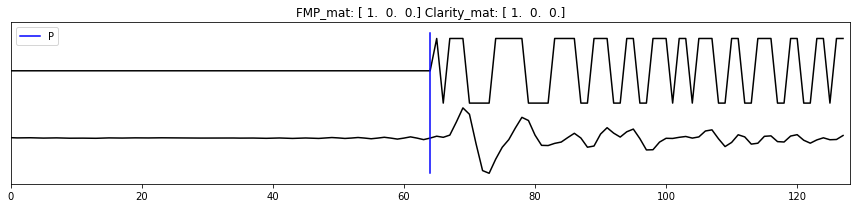

In [40]:
data_length = 128
temp_X, temp_Y = get_instance_for_FirstMotionPolarity_training(dataset_name='DiTing', dataset_path=DiTingDatasetPath, data_length=data_length, part = part, key = key, motion=p_motion, sharpness=p_sharpness, P=p_t)

plt.figure(figsize=(12,3))
for chdx in range(2):
    temp_plot = temp_X[:,chdx]
    temp_plot -= np.mean(temp_plot)
    temp_plot /= np.max(np.abs(temp_plot))
    plt.plot(temp_plot + chdx*2, color='k' )
plt.plot([data_length//2,data_length//2],[-1,3],color='b',label='P')
plt.ylim([-1.3,3.3])
plt.xlim([0,temp_plot.shape[0]])
plt.yticks([])
plt.title('FMP_mat: {} Clarity_mat: {}'.format(temp_Y[0,:], temp_Y[1,:]))
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

## SCSN-FMP dataset
## SCSN-FMP 数据集

In [41]:
# 在此修改数据集路径
# change path here
SCSN_FMP_DatasetPath = '/mnt/GPT_disk/DL_datasets/SCSN_FM/scsn_p_2000_2017_6sec_0.5r_fm_train.hdf5'
fmp_list = ['U','D','-']

In [14]:
train_fmp_h5 = h5py.File('/mnt/GPT_disk/DL_datasets/SCSN_FM/scsn_p_2000_2017_6sec_0.5r_fm_train.hdf5','r')

In [17]:
len(train_fmp_h5['X'])

2494194

In [18]:
test_fmp_h5 = h5py.File('/mnt/GPT_disk/DL_datasets/SCSN_FM/scsn_p_2000_2017_6sec_0.5r_fm_test.hdf5','r')

In [19]:
len(test_fmp_h5['X'])

2353054

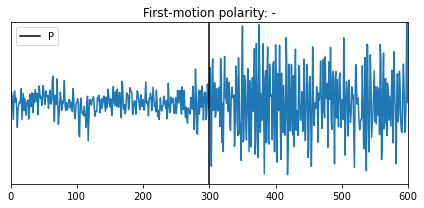

In [42]:
index_key = np.random.randint(400000)
waveform, label = get_from_SCSN_FMP(index = index_key, h5file_path=SCSN_FMP_DatasetPath)
plt.figure(figsize=(6,3))
plt.plot(waveform)
plt.plot([300,300],[-1,1],color='k',label='P')
plt.ylim([-1,1])
plt.xlim([0,600])
plt.yticks([])
plt.title('First-motion polarity: {}'.format(fmp_list[int(label)]))
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [43]:
from dtt.dev.fmp.data import get_FMP_training_dataset

In [44]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import tensorflow as tf
import yaml
# load configs
cfgs = yaml.load(open('../example_configs/fmp_example.yaml','r'),Loader=yaml.Loader)

In [45]:
training_dataset, validation_data_gen = get_FMP_training_dataset(cfgs)

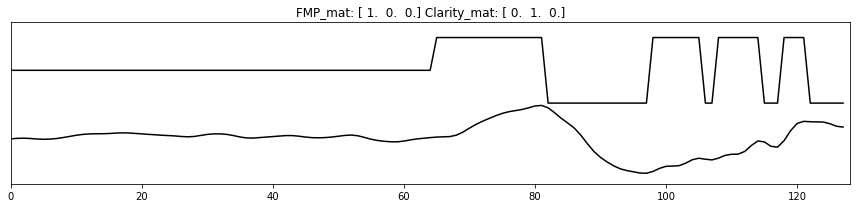

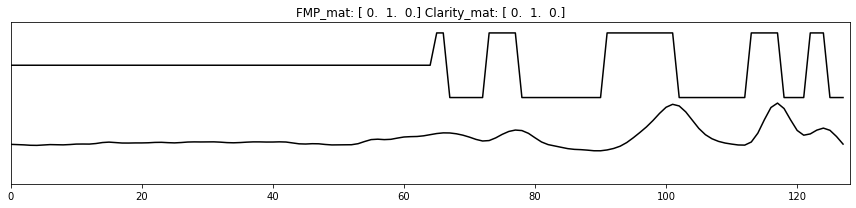

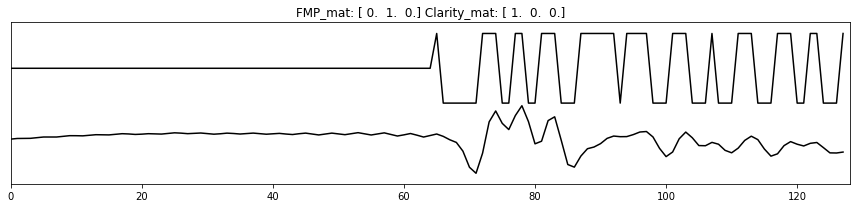

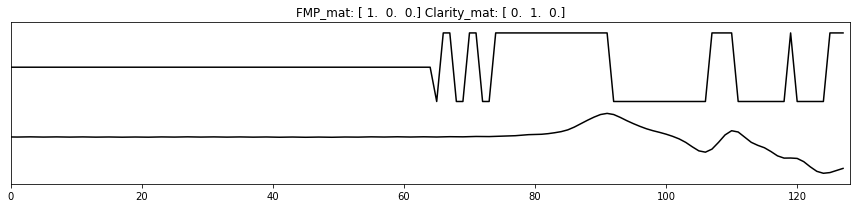

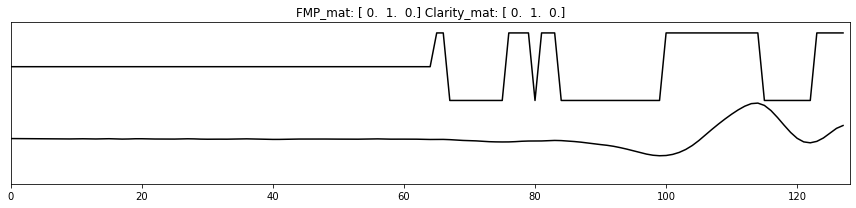

In [46]:
batch_size = 5
for output_data in training_dataset.batch(batch_size).take(1):
    for batch_dx in range(batch_size):
        plt.figure(figsize=(12,3))
        plot_half_length = 50
        for chdx in range(2):
            temp_plot = output_data[0].numpy()[batch_dx,:,chdx]
            temp_plot -= np.mean(temp_plot)
            temp_plot /= np.max(np.abs(temp_plot))
            plt.plot(temp_plot + chdx*2, color='k' )
        plt.ylim([-1.3,3.3])
        plt.xlim([0,temp_plot.shape[0]])
        plt.yticks([])
        plt.title('FMP_mat: {} Clarity_mat: {}'.format(output_data[1]['T0D0'][batch_dx,:], output_data[1]['T1D0'][batch_dx,:]))
        plt.tight_layout()
        plt.show()
        plt.close()

# Azi TFDataset Visualization
# 方位角估算数据集可视化

In [5]:
from dtt.dev.azi.data import get_instance_for_BAZReg_training, get_Azi_training_dataset, azi2baz

In [6]:
# 在此修改数据集路径
# change path here
DiTingDatasetPath = '/mnt/GPT_disk/DL_datasets/DiTing330km_publish_50Hz/'
# 加载数据集CSV文件
# load csv file
DiTing_330km_csv = pd.read_csv(DiTingDatasetPath + 'DiTing330km_total.csv',dtype = {'key': str})
DiTing_azi_sub_csv =  DiTing_330km_csv[pd.to_numeric(DiTing_330km_csv['baz'], errors='coerce').notnull()]

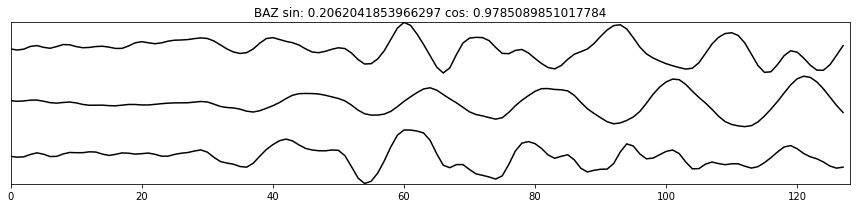

In [7]:
# check waveform and label
random_id = np.random.randint(len(DiTing_azi_sub_csv))
random_line = DiTing_azi_sub_csv.iloc[random_id]

part = random_line['part']
key = random_line['key']
key_correct = key.split('.')
key = key_correct[0].rjust(6,'0') + '.' + key_correct[1].ljust(4,'0')
p_t = (random_line['p_pick'] *2)

# label to be corrected!
baz = azi2baz( float(random_line['baz']) )

waveform, label = get_instance_for_BAZReg_training(part=part, key=key, dataset_name='DiTing',dataset_path=DiTingDatasetPath, length_before_P=28, length_after_P=100, P = p_t, baz=baz)

plt.figure(figsize=(12,3))
for chdx in range(3):
    temp_plot = waveform[:,chdx] 
    temp_plot -= np.mean(temp_plot)
    temp_plot /= np.max(np.abs(temp_plot))
    plt.plot(temp_plot + chdx*2, color='k' )
plt.ylim([-1,5])
plt.xlim([0,temp_plot.shape[0]])
plt.yticks([])
plt.title('BAZ sin: {} cos: {}'.format(label[0], label[1]))
plt.tight_layout()
plt.show()
plt.close()

In [8]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import tensorflow as tf
import yaml
# load configs
cfgs = yaml.load(open('../example_configs/baz_example.yaml','r'),Loader=yaml.Loader)

In [9]:
training_dataset, validation_data_gen = get_Azi_training_dataset(cfgs)

2022-07-18 13:08:22.399292: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-07-18 13:08:23.938518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:b1:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2022-07-18 13:08:23.939158: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-07-18 13:08:23.941679: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-18 13:08:23.944142: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-07-18 13:08:23.944795: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

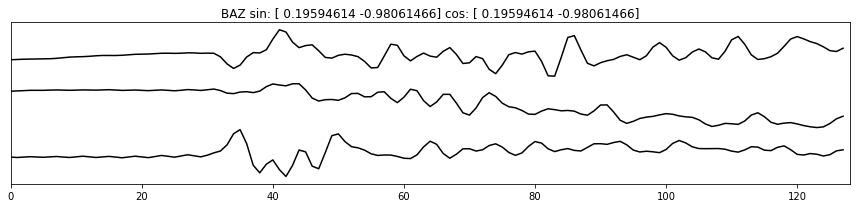

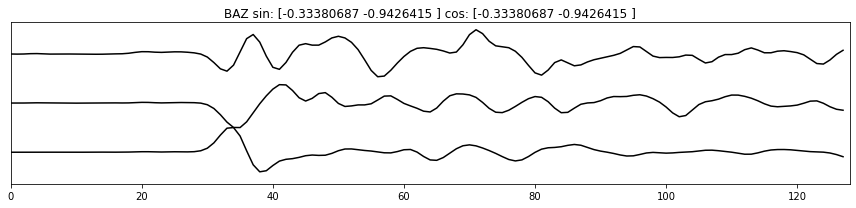

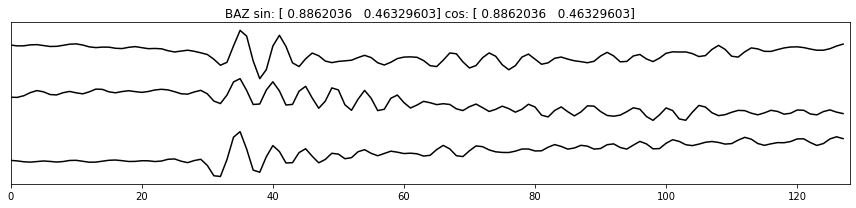

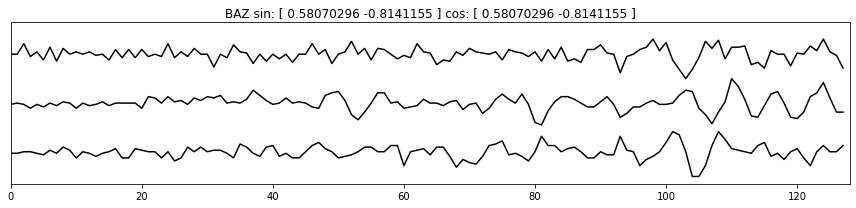

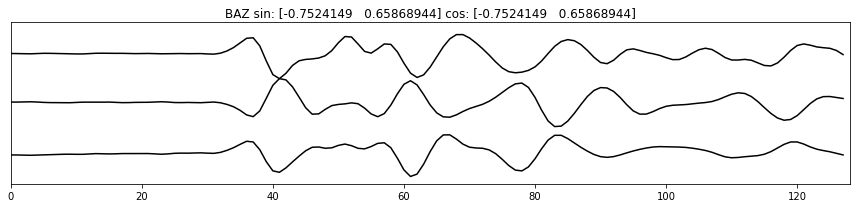

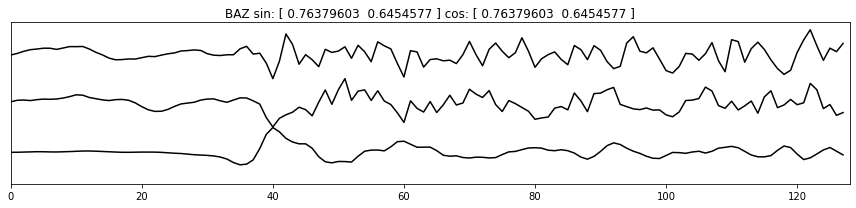

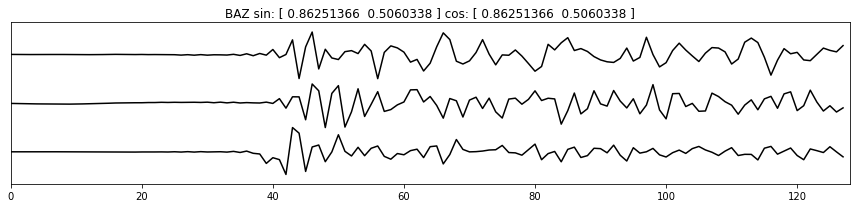

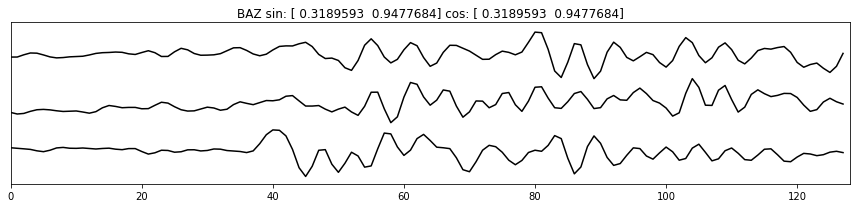

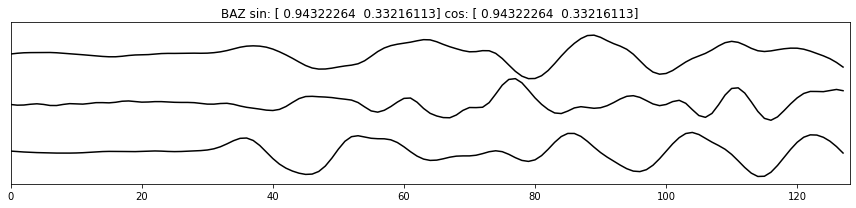

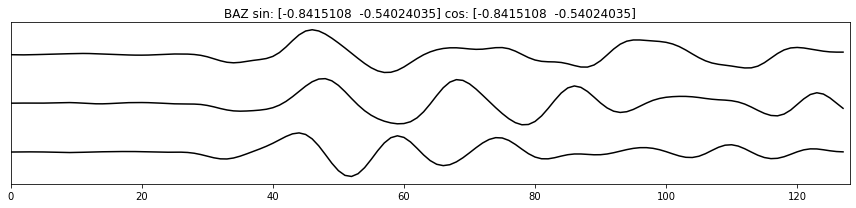

In [13]:
batch_size = 10
for output_data in training_dataset.batch(batch_size).take(1):
    for batch_dx in range(batch_size):
        plt.figure(figsize=(12,3))
        plot_half_length = 50
        for chdx in range(3):
            temp_plot = output_data[0].numpy()[batch_dx,:,chdx]
            temp_plot -= np.mean(temp_plot)
            temp_plot /= np.max(np.abs(temp_plot))
            plt.plot(temp_plot + chdx*2, color='k' )
        plt.ylim([-1.3,5.3])
        plt.xlim([0,temp_plot.shape[0]])
        plt.yticks([])
        plt.title('BAZ sin: {} cos: {}'.format(output_data[1][batch_dx,:], output_data[1][batch_dx,:]))
        plt.tight_layout()
        plt.show()
        plt.close()

# MagTFDataset Visualization
# 方位角估算数据集可视化

In [5]:
from dtt.dev.mag.data import get_instance_for_MagReg_training, get_Mag_training_dataset

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import tensorflow as tf
import yaml
# load configs
cfgs = yaml.load(open('../example_configs/mag_example.yaml','r'),Loader=yaml.Loader)

In [7]:
# 在此修改数据集路径
# change path here
DiTingDatasetPath = '/mnt/GPT_disk/DL_datasets/DiTing330km_publish_50Hz/'
# 加载数据集CSV文件
# load csv file
DiTing_330km_csv = pd.read_csv(DiTingDatasetPath + 'DiTing330km_total.csv',dtype = {'key': str})
DiTing_azi_sub_csv =  DiTing_330km_csv[pd.to_numeric(DiTing_330km_csv['evmag'], errors='coerce').notnull()]

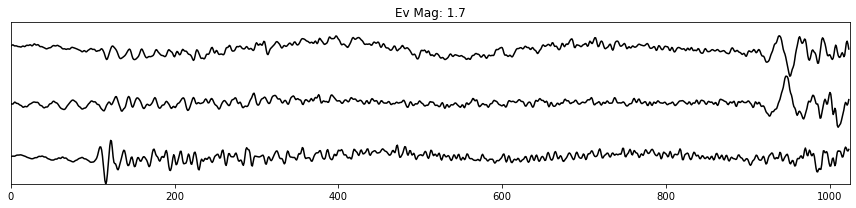

In [8]:
# check waveform and label
random_id = np.random.randint(len(DiTing_azi_sub_csv))
random_line = DiTing_azi_sub_csv.iloc[random_id]

part = random_line['part']
key = random_line['key']
key_correct = key.split('.')
key = key_correct[0].rjust(6,'0') + '.' + key_correct[1].ljust(4,'0')
p_t = (random_line['p_pick'] *2)
mag = float(random_line['evmag'])

waveform, label = get_instance_for_MagReg_training(part=part, key=key, dataset_name='DiTing',dataset_path=DiTingDatasetPath, length_before_P=100, length_after_P=924, P = p_t, mag=mag)

plt.figure(figsize=(12,3))
for chdx in range(3):
    temp_plot = waveform[:,chdx] 
    temp_plot -= np.mean(temp_plot)
    temp_plot /= np.max(np.abs(temp_plot))
    plt.plot(temp_plot + chdx*2, color='k' )
plt.ylim([-1,5])
plt.xlim([0,temp_plot.shape[0]])
plt.yticks([])
plt.title('Ev Mag: {:.1f}'.format(label[0]*10))
plt.tight_layout()
plt.show()
plt.close()

In [9]:
training_dataset, validation_data_gen = get_Mag_training_dataset(cfgs)

2022-07-18 13:54:42.304418: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-07-18 13:54:44.029473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:b1:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2022-07-18 13:54:44.030128: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-07-18 13:54:44.032702: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-18 13:54:44.035214: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-07-18 13:54:44.035863: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

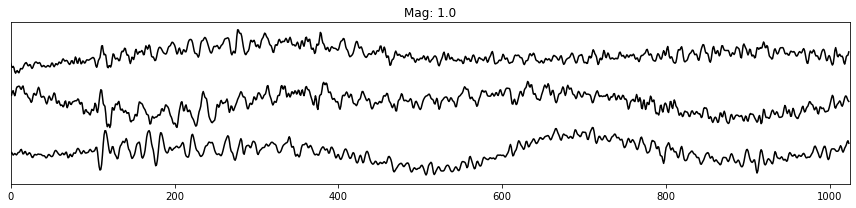

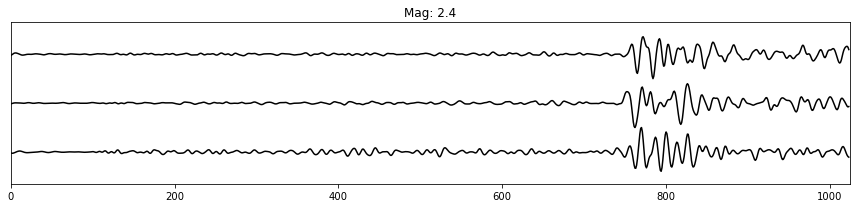

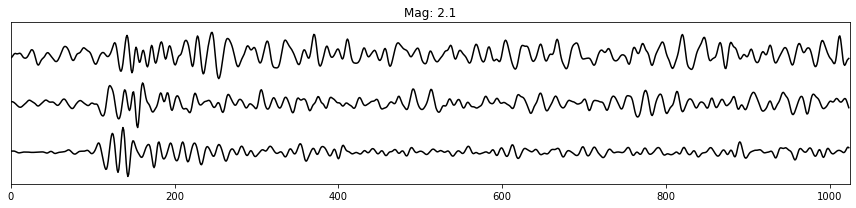

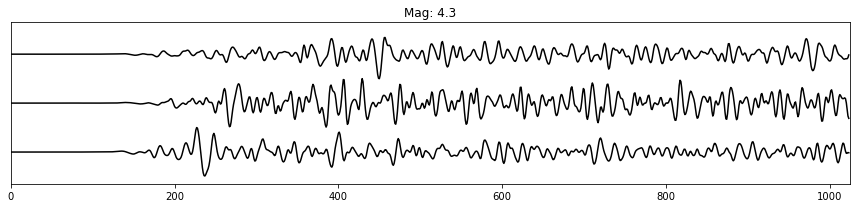

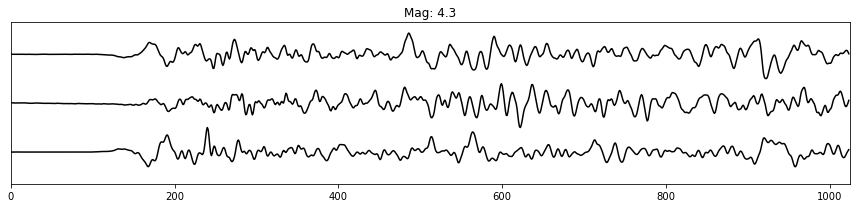

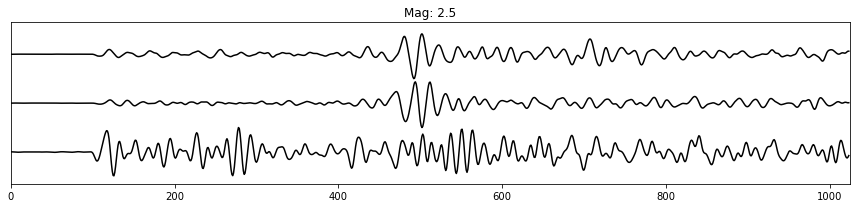

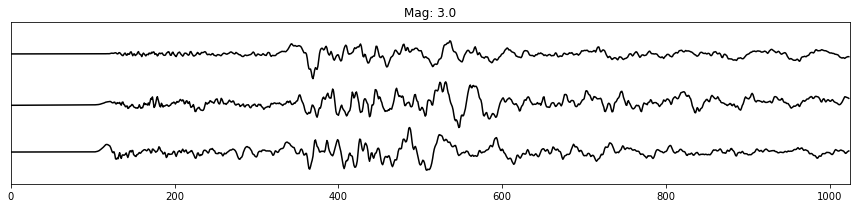

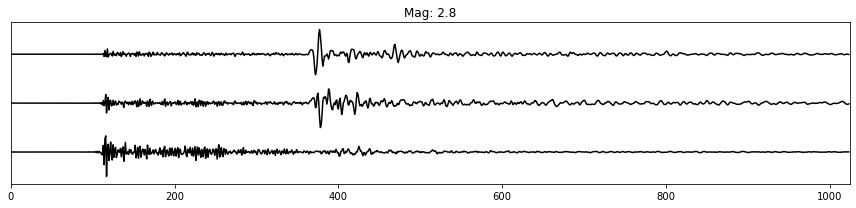

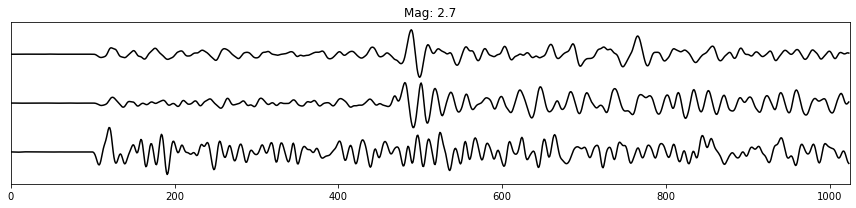

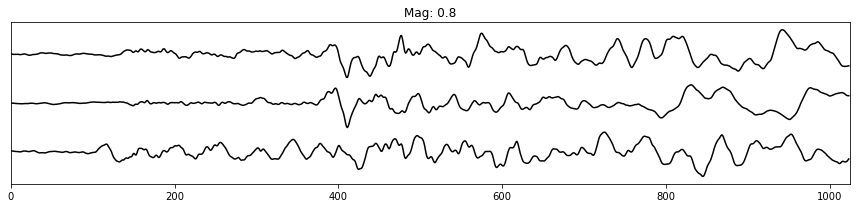

In [13]:
batch_size = 10
for output_data in training_dataset.batch(batch_size).take(1):
    for batch_dx in range(batch_size):
        plt.figure(figsize=(12,3))
        plot_half_length = 50
        for chdx in range(3):
            temp_plot = output_data[0].numpy()[batch_dx,:,chdx]
            temp_plot -= np.mean(temp_plot)
            temp_plot /= np.max(np.abs(temp_plot))
            plt.plot(temp_plot + chdx*2, color='k' )
        plt.ylim([-1.3,5.3])
        plt.xlim([0,temp_plot.shape[0]])
        plt.yticks([])
        plt.title('Mag: {:.1f}'.format(output_data[1][batch_dx,0]*10))
        plt.tight_layout()
        plt.show()
        plt.close()

# 其它数据集访问示例

## SCSN-P dataset
## SCSN-P 数据集

In [47]:
# 在此修改数据集路径
# change path here
SCSN_P_DatasetPath = '/mnt/GPT_disk/DL_datasets/SCSN_FM/scsn_p_2000_2017_6sec_0.5r_pick_train.hdf5'

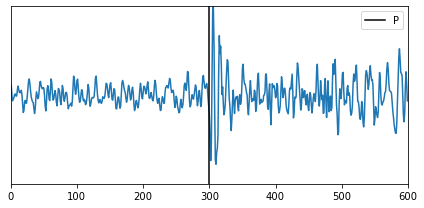

In [48]:
index_key = np.random.randint(10000)
waveform = get_from_SCSN_P(index = index_key, h5file_path=SCSN_P_DatasetPath)
plt.figure(figsize=(6,3))
plt.plot(waveform)
plt.plot([300,300],[-1,1],color='k',label='P')
plt.ylim([-1,1])
plt.xlim([0,600])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

## NEIC dataset
## NEIC 数据集


In [49]:
NEIC_DatasetPath = '/public/data0/NEIC_dataset/'

In [50]:
NEIC_P_train = np.load(NEIC_DatasetPath + 'PWF_Train.npy', mmap_mode = 'r')

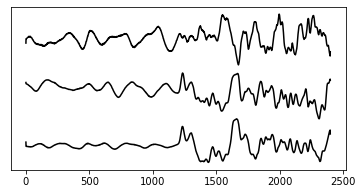

In [51]:
check_id = np.random.randint(low=0,high=NEIC_P_train.shape[0])
plt.figure(figsize=(6,3))
for chdx in range(3):
    plot_data = NEIC_P_train[check_id,chdx,:].copy()
    plot_data -= np.mean(plot_data)
    plot_data /= np.max(np.abs(plot_data))
    plt.plot(plot_data + chdx*2,color='k')
plt.yticks([])
plt.show()
plt.close()

In [52]:
NEIC_S_train = np.load(NEIC_DatasetPath + 'SWF_Train.npy', mmap_mode = 'r')

In [53]:
np.shape(NEIC_S_train)

(264274, 3, 2400)

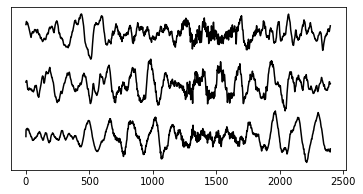

In [54]:
check_id = np.random.randint(low=0,high=NEIC_S_train.shape[0])
plt.figure(figsize=(6,3))
for chdx in range(3):
    plot_data = NEIC_S_train[check_id,chdx,:].copy()
    plot_data -= np.mean(plot_data)
    plot_data /= np.max(np.abs(plot_data))
    plt.plot(plot_data + chdx*2,color='k')
plt.yticks([])
plt.show()
plt.close()